<a href="https://colab.research.google.com/github/efandresena/brics-astronomy-capstone-project/blob/main/ZPrime_detection_fandresena_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Z' Boson Detection Using Machine Learning at the Large Hadron Collider
---
 ### Objective
--

 Even though the Standard Model (SM) of particle physic is very succesfull in describing the interaction of the known fundamental particles like quarks and leptons through force carriers (bosons) like the photon and gluon, it still can’t explain many phenomena of the universe. For example, we don’t yet understand what is the origin of dark matter and dark energy, which together make up more than 95% of the universe. If a new theory beyond the SM is true, it may predict new physics from these dark area. Like the Z′ boson, which are similar to the photon, some theory admit that if they exist they can be used as portal to interact with these dark matter[].

In this project, we use simulated collision data from CERN to try to detect these Z′ bosons using Machine Learning. We train a Random Forest classifier to separate signal events (where Z′ → tt̄ happens) from background Standard Model processes. However, since each event has more than 100+ variables, this bring us to a problem called the "curse of dimensionality" [2], where the model perform worse when there are too many irrelevant or redundant features. So we try to reduce the number of variables by removing unimportant ones using physical reasoning and statistical analysis.

Then we select the best features and train the model, and evaluate if it can really detect the Z′ if the theory is true.


### Dataset Description

This project uses simulated particle physics data provided by CERN’s Open Data portal, converted from ROOT to HDF5 format by Lars Erik Risholm (via Kaggle) to enable easier data analysis using Python. These simulations reproduce what might happen in high-energy proton-proton collisions at the Large Hadron Collider (LHC), including both known Standard Model processes and hypothetical ones.

---

**Dataset Composition**

- **Signal Data**  
  These are simulated events where a hypothetical **Z′ boson** is produced in a proton-proton collision and decays into a pair of top quarks (`tt̄`).  
  - In high-energy physics, Z′ is a proposed heavier version of the Z boson, predicted by some theories beyond the Standard Model (BSM), such as U(1) extensions.
  - Each signal sample corresponds to a specific Z′ mass (500 GeV to 2500 GeV), reflecting how it might appear in detectors if real.

  

- **Background Data**  
  These are Standard Model (SM) processes that can mimic the signal, even though they don't involve a Z′ boson. They include:
  - ***tt̄ (top–antitop)***: one of the main backgrounds, as it has the same final state as the Z′ signal.
  - ***Single top***: a single top quark produced with other particles.
  - ***Z/W boson production***: includes decays into leptons (`Z → ee, μμ, ττ`, `W → lν`).
  - ***Drell–Yan***: a common SM process producing leptons via virtual photon/Z exchange.
  - ***Diboson (WW, WZ, ZZ)***: two-boson events that can produce similar final states.
  - ***W + jets (especially b-quarks)***: background from jets faking leptons or b-tag signatures.

  These processes often produce detector signatures that look similar to a Z′ decay. A good classifier needs to separate signal from this complex background.




**Data Features (Inputs)**

Each event (row in the dataset) describes the final state of a collision and contains over 100 features. These can be grouped into meaningful categories:

---

🔹 ***Jet Features (`jet_*`)***  
Jets are sprays of particles originating from quarks or gluons.  
Each jet has 10–12 associated variables. For example:

- `jet_1_E`, `jet_1_pt`, `jet_1_eta`, `jet_1_phi`, `jet_1_m`: basic kinematics (energy, momentum, angle, mass)
- `jet_1_MV1`, `jet_1_SV0`: b-tagging scores (indicators whether jet came from a b-quark)
- `jet_1_jvf`: jet vertex fraction — related to pile-up (secondary collision contamination)
- `jet_1_trueflav`, `jet_1_truthMatched`: truth-level labels from simulation (not available in real experiments)

There are up to 10 jets per event (`jet_1_` to `jet_9_`). The total number of reconstructed jets per event is stored in `jet_n`.

---

🔹 ***Lepton Features (`lep_*`)***  
Leptons are electrons or muons. Each lepton has:

- `lep_1_E`, `lep_1_pt`, `lep_1_eta`, `lep_1_phi`: energy, momentum, direction
- `lep_1_charge`, `lep_1_type`: sign of charge (+/-), type of lepton
- `lep_1_etcone20`, `ptcone30`: isolation variables — how "clean" the lepton environment is
- `trackd0pvunbiased`, `tracksigd0pvunbiased`, `z0`: related to impact parameter (origin of lepton track)

There are up to 5 leptons per event. `lep_n` gives the total number of leptons.

---

🔹 ***Event-Level Features***

These summarize properties of the whole collision event:

- `met_et`, `met_phi`: missing transverse energy (important for undetected particles like neutrinos)
- `pvxp_n`, `vxp_z`: number and position of primary vertices (related to interaction point)
- `mcWeight`: Monte Carlo weight for scaling simulated events
- `scaleFactor_*`: correction weights (e.g., for detector efficiency and pile-up modeling)
- `runNumber`, `eventNumber`, `channelNumber`: metadata identifiers

---




 ### Data Cleaning/Preprocessing

In [ ]:
# Importing the necessary packages
import h5py  # to read hdf5 files
import os   # to navigate through the file directory
import gc   # for garbage collection and memory management

# For data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # For progress bars

# For machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [ ]:
# For the dataset download
import kagglehub

# Download latest version
path = kagglehub.dataset_download("larserikrisholm/zparticlesearch")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/zparticlesearch


In [ ]:
print(os.listdir(path))

['Signal_test_only', 'mc_110901.ZPrime500', 'allfiles']


In [ ]:
signal_test_only_path = os.path.join(path,'Signal_test_only')
print(os.listdir(signal_test_only_path))

['mc_110908.ZPrime2250.hdf5', 'mc_110904.ZPrime1250.hdf5']


In [ ]:
dataset_path = os.path.join(path,'allfiles/allfiles')
print(os.listdir(dataset_path))

['mc_167740.WenuWithB.hdf5', 'mc_173045.DYtautauM08to15.hdf5', 'mc_173042.DYeeM15to40.hdf5', 'mc_110140.stop_wtchan.hdf5', 'mc_147770.Zee.hdf5', 'mc_117049.ttbar_had.hdf5', 'mc_105987.WZ.hdf5', 'mc_173041.DYeeM08to15.hdf5', 'mc_110908.ZPrime2250.hdf5', 'mc_110091.stop_tchan_antitop.hdf5', 'mc_110904.ZPrime1250.hdf5', 'mc_147771.Zmumu.hdf5', 'mc_173046.DYtautauM15to40.hdf5', 'mc_110902.ZPrime750.hdf5', 'mc_173043.DYmumuM08to15.hdf5', 'mc_110906.ZPrime1750.hdf5', 'mc_110903.ZPrime1000.hdf5', 'mc_110901.ZPrime500.hdf5', 'mc_167746.WtaunuWithB.hdf5', 'mc_147772.Ztautau.hdf5', 'mc_173044.DYmumuM15to40.hdf5', 'mc_110090.stop_tchan_top.hdf5', 'mc_110905.ZPrime1500.hdf5', 'mc_117050.ttbar_lep.hdf5', 'mc_105986.ZZ.hdf5', 'mc_110119.stop_schan.hdf5', 'mc_167743.WmunuWithB.hdf5', 'mc_110907.ZPrime2000.hdf5', 'mc_110909.ZPrime2500.hdf5']


In [ ]:
 # List HDF5 files
s_test_files = [f for f in os.listdir(signal_test_only_path) if f.endswith('.hdf5')]
s_files = [f for f in os.listdir(dataset_path) if f.__contains__('ZPrime') and f.endswith('.hdf5') and f not in s_test_files]
b_files = [f for f in os.listdir(dataset_path) if f.endswith('.hdf5') and f not in s_files]

print(f"Signal test only files: {(s_test_files)}")
print(f"Signal files: {(s_files)}")
print(f"Background files: {(b_files)}")


Signal test only files: ['mc_110908.ZPrime2250.hdf5', 'mc_110904.ZPrime1250.hdf5']
Signal files: ['mc_110902.ZPrime750.hdf5', 'mc_110906.ZPrime1750.hdf5', 'mc_110903.ZPrime1000.hdf5', 'mc_110901.ZPrime500.hdf5', 'mc_110905.ZPrime1500.hdf5', 'mc_110907.ZPrime2000.hdf5', 'mc_110909.ZPrime2500.hdf5']
Background files: ['mc_167740.WenuWithB.hdf5', 'mc_173045.DYtautauM08to15.hdf5', 'mc_173042.DYeeM15to40.hdf5', 'mc_110140.stop_wtchan.hdf5', 'mc_147770.Zee.hdf5', 'mc_117049.ttbar_had.hdf5', 'mc_105987.WZ.hdf5', 'mc_173041.DYeeM08to15.hdf5', 'mc_110908.ZPrime2250.hdf5', 'mc_110091.stop_tchan_antitop.hdf5', 'mc_110904.ZPrime1250.hdf5', 'mc_147771.Zmumu.hdf5', 'mc_173046.DYtautauM15to40.hdf5', 'mc_173043.DYmumuM08to15.hdf5', 'mc_167746.WtaunuWithB.hdf5', 'mc_147772.Ztautau.hdf5', 'mc_173044.DYmumuM15to40.hdf5', 'mc_110090.stop_tchan_top.hdf5', 'mc_117050.ttbar_lep.hdf5', 'mc_105986.ZZ.hdf5', 'mc_110119.stop_schan.hdf5', 'mc_167743.WmunuWithB.hdf5']


In [ ]:

# Print the number of files found
print(f"Number of background files: {len(b_files)}")
print(f"Number of signal files: {len(s_files)}")
print(f"Number of signal test files: {len(s_test_files)}")

# Check the structure of one file to find the dataset name stored in the files
try:
    with h5py.File(os.path.join(dataset_path, b_files[0]), 'r') as f:
        datasets = list(f.keys())
        print(f"Dataset name found: {datasets}")

        # Check the shape and basic info
        dataset_shape = f[datasets[0]].shape
        print(f"Dataset shape: {dataset_shape}")

except Exception as e:
    print(f"Error reading file structure: {e}")


Number of background files: 22
Number of signal files: 7
Number of signal test files: 2
Dataset name found: ['mini']
Dataset shape: (750000,)


 Since there is only one dataset per file (named 'mini'), we will use this for all our data loading operations. The operation of hdf5 file can be found at this documentation [].

In [ ]:
def process_files(path, files):
    """
    Process HDF5 files and combine them into a single DataFrame.

    Parameters:
    - path: Directory path containing the files
    - files: List of file names to process

    Returns:
    - combined_df: Combined DataFrame with all processed data
    """
    dataset_name = 'mini'
    combined_data = {}

    for file in tqdm(files, desc=f"Processing {path} files", unit="file"):
        file_path = os.path.join(path, file)

        try:
            with h5py.File(file_path, 'r') as f:
                if dataset_name not in f:
                    print(f"Error: Dataset '{dataset_name}' not found in {file}")
                    continue

                # Load data with limited number of event for memory efficiency
                data_slice = f[dataset_name][:90000]
                df = pd.DataFrame(data_slice)

                # Add 'status' column (0 for background, 1 for signal)
                if 'ZPrime' in f'{file}':
                    df['status'] = 1
                else:
                    df['status'] = 0

                combined_data[file] = df

        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

        # Memory cleanup
        del df, data_slice
        gc.collect()

    # Concatenate all successfully loaded DataFrames
    if combined_data:
        combined_df = pd.concat(combined_data.values(), ignore_index=True)
        print(f"Successfully loaded {len(combined_df)} events from {len(combined_data)} files")
        return combined_df
    else:
        print("Warning: No data was loaded successfully")
        return pd.DataFrame()


In [ ]:
# Process background and signal files
print("Loading background data...")
background_df = process_files(dataset_path, b_files)

print("\nLoading signal data...")
signal_df = process_files(dataset_path, s_files)

print(f"\nData loading summary:")
print(f"Background events: {len(background_df)}")
print(f"Signal events: {len(signal_df)}")


Loading background data...


Processing /kaggle/input/zparticlesearch/allfiles/allfiles files: 100%|██████████| 22/22 [00:07<00:00,  2.87file/s]


Successfully loaded 963713 events from 22 files

Loading signal data...


Processing /kaggle/input/zparticlesearch/allfiles/allfiles files: 100%|██████████| 7/7 [00:01<00:00,  3.52file/s]

Successfully loaded 163308 events from 7 files

Data loading summary:
Background events: 963713
Signal events: 163308


 ### Exploratory Data Analysis (EDA)

 #### Statistical Summary of the Data

In [ ]:
# Set the option to display all columns for better inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Display basic information about the datasets
print("=== BACKGROUND DATA OVERVIEW ===")
print(f"Shape: {background_df.shape}")
print(f"Memory usage: {background_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst 5 rows:")
background_df.head()


=== BACKGROUND DATA OVERVIEW ===
Shape: (963713, 170)
Memory usage: 628.64 MB

First 5 rows:


,alljet_n,channelNumber,eventNumber,jet_1_E,jet_1_MV1,jet_1_SV0,jet_1_eta,jet_1_jvf,jet_1_m,jet_1_phi,jet_1_pt,jet_1_trueflav,jet_1_truthMatched,jet_2_E,jet_2_MV1,jet_2_SV0,jet_2_eta,jet_2_jvf,jet_2_m,jet_2_phi,jet_2_pt,jet_2_trueflav,jet_2_truthMatched,jet_3_E,jet_3_MV1,jet_3_SV0,jet_3_eta,jet_3_jvf,jet_3_m,jet_3_phi,jet_3_pt,jet_3_trueflav,jet_3_truthMatched,jet_4_E,jet_4_MV1,jet_4_SV0,jet_4_eta,jet_4_jvf,jet_4_m,jet_4_phi,jet_4_pt,jet_4_trueflav,jet_4_truthMatched,jet_5_E,jet_5_MV1,jet_5_SV0,jet_5_eta,jet_5_jvf,jet_5_m,jet_5_phi,jet_5_pt,jet_5_trueflav,jet_5_truthMatched,jet_6_E,jet_6_MV1,jet_6_SV0,jet_6_eta,jet_6_jvf,jet_6_m,jet_6_phi,jet_6_pt,jet_6_trueflav,jet_6_truthMatched,jet_7_E,jet_7_MV1,jet_7_SV0,jet_7_eta,jet_7_jvf,jet_7_m,jet_7_phi,jet_7_pt,jet_7_trueflav,jet_7_truthMatched,jet_8_E,jet_8_MV1,jet_8_SV0,jet_8_eta,jet_8_jvf,jet_8_m,jet_8_phi,jet_8_pt,jet_8_trueflav,jet_8_truthMatched,jet_9_E,jet_9_MV1,jet_9_SV0,jet_9_eta,jet_9_jvf,jet_9_m,jet_9_phi,jet_9_pt,jet_9_trueflav,jet_9_truthMatched,jet_n,lep_1_E,lep_1_charge,lep_1_eta,lep_1_etcone20,lep_1_flag,lep_1_phi,lep_1_pt,lep_1_ptcone30,lep_1_trackd0pvunbiased,lep_1_tracksigd0pvunbiased,lep_1_type,lep_1_z0,lep_2_E,lep_2_charge,lep_2_eta,lep_2_etcone20,lep_2_flag,lep_2_phi,lep_2_pt,lep_2_ptcone30,lep_2_trackd0pvunbiased,lep_2_tracksigd0pvunbiased,lep_2_type,lep_2_z0,lep_3_E,lep_3_charge,lep_3_eta,lep_3_etcone20,lep_3_flag,lep_3_phi,lep_3_pt,lep_3_ptcone30,lep_3_trackd0pvunbiased,lep_3_tracksigd0pvunbiased,lep_3_type,lep_3_z0,lep_4_E,lep_4_charge,lep_4_eta,lep_4_etcone20,lep_4_flag,lep_4_phi,lep_4_pt,lep_4_ptcone30,lep_4_trackd0pvunbiased,lep_4_tracksigd0pvunbiased,lep_4_type,lep_4_z0,lep_5_E,lep_5_charge,lep_5_eta,lep_5_etcone20,lep_5_flag,lep_5_phi,lep_5_pt,lep_5_ptcone30,lep_5_trackd0pvunbiased,lep_5_tracksigd0pvunbiased,lep_5_type,lep_5_z0,lep_n,lep_trigMatched,mcWeight,met_et,met_phi,pvxp_n,runNumber,scaleFactor_BTAG,scaleFactor_ELE,scaleFactor_JVFSF,scaleFactor_MUON,scaleFactor_PILEUP,scaleFactor_TRIGGER,scaleFactor_ZVERTEX,vxp_z,status
0,1,167740,1035,34664.371094,0.052396,0.000000,0.683307,0.330386,5556.949219,2.155222,27534.085938,5,1,41001.3125,0.056153,0.0,-0.422173,1.0,9000.279297,2.57151,36683.402344,0,1,39873.675781,0.055984,0.0,-0.675168,1.0,5538.464355,-0.457599,31929.013672,0,1,31185.908203,0.057743,0.0,-0.522071,1.0,4468.95459,-2.872609,27087.917969,0,1,32476.650391,0.052396,0.0,-0.604523,0.056113,4372.974121,-0.394291,27080.15625,0,0,97916.898438,0.053409,0.0,1.533484,0.949615,7885.665527,-3.09035,40246.3125,0,1,35631.566406,0.057781,0.0,-0.583896,0.88019,7079.005859,-2.570127,29710.994141,0,1,63485.960938,0.056771,0.0,-1.344351,0.450512,6055.004395,-2.746005,30854.640625,0,1,41935.308594,0.057157,0.0,-0.879078,0.732159,4827.222168,-2.361078,29503.431641,0,1,0,51672.109375,1.0,-0.812187,530.559814,1309098368,-3.062526,38322.250000,0.000000,-0.009394,0.019931,1093664768,-0.050797,8414.746094,-1.0,-0.938133,0.0,1254113278,2.0487,5711.112793,1264.463989,0.046162,0.035955,1095761920,-0.017691,24765.291016,1.0,-1.9183,-331.314056,1300955648,-2.453468,7120.258301,0.0,0.004684,0.044692,1095761920,0.117558,32115.34375,-1.0,-2.434522,2163.104736,1241538556,-0.186899,5586.214844,7660.961426,-0.004614,0.056943,1095761920,0.38236,7053.571777,1.0,0.711662,1248.767578,1300299968,1.027748,5579.283691,4147.015137,0.121623,0.031699,1095761920,-0.469976,1,1,1.0,38011.132812,-0.104367,7,195848,1.0000,0.955131,1.0,1.0,1.054852,0.973873,0.519217,88.246147,0
1,1,167740,1049,42260.152344,0.994451,20.948668,-0.167521,1.000000,6178.273438,1.895429,41226.269531,5,1,41001.3125,0.056153,0.0,-0.422173,1.0,9000.279297,2.57151,36683.402344,0,1,39873.675781,0.055984,0.0,-0.675168,1.0,5538.464355,-0.457599,31929.013672,0,1,31185.908203,0.057743,0.0,-0.522071,1.0,4468.95459,-2.872609,27087.917969,0,1,32476.650391,0.052396,0.0,-0.604523,0.056113,4372.974121,-0.394291,27080.15625,0,0,97916.898438,0.053409,0.0,1.533484,0.949615,7885.665527,-3.09035,40246.3125,0,1,35631.566406,0.057781,0

In [ ]:

print("\n=== SIGNAL DATA OVERVIEW ===")
print(f"Shape: {signal_df.shape}")
print(f"Memory usage: {signal_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst 5 rows:")
signal_df.head()



=== SIGNAL DATA OVERVIEW ===
Shape: (163308, 170)
Memory usage: 106.53 MB

First 5 rows:


,alljet_n,channelNumber,eventNumber,jet_1_E,jet_1_MV1,jet_1_SV0,jet_1_eta,jet_1_jvf,jet_1_m,jet_1_phi,jet_1_pt,jet_1_trueflav,jet_1_truthMatched,jet_2_E,jet_2_MV1,jet_2_SV0,jet_2_eta,jet_2_jvf,jet_2_m,jet_2_phi,jet_2_pt,jet_2_trueflav,jet_2_truthMatched,jet_3_E,jet_3_MV1,jet_3_SV0,jet_3_eta,jet_3_jvf,jet_3_m,jet_3_phi,jet_3_pt,jet_3_trueflav,jet_3_truthMatched,jet_4_E,jet_4_MV1,jet_4_SV0,jet_4_eta,jet_4_jvf,jet_4_m,jet_4_phi,jet_4_pt,jet_4_trueflav,jet_4_truthMatched,jet_5_E,jet_5_MV1,jet_5_SV0,jet_5_eta,jet_5_jvf,jet_5_m,jet_5_phi,jet_5_pt,jet_5_trueflav,jet_5_truthMatched,jet_6_E,jet_6_MV1,jet_6_SV0,jet_6_eta,jet_6_jvf,jet_6_m,jet_6_phi,jet_6_pt,jet_6_trueflav,jet_6_truthMatched,jet_7_E,jet_7_MV1,jet_7_SV0,jet_7_eta,jet_7_jvf,jet_7_m,jet_7_phi,jet_7_pt,jet_7_trueflav,jet_7_truthMatched,jet_8_E,jet_8_MV1,jet_8_SV0,jet_8_eta,jet_8_jvf,jet_8_m,jet_8_phi,jet_8_pt,jet_8_trueflav,jet_8_truthMatched,jet_9_E,jet_9_MV1,jet_9_SV0,jet_9_eta,jet_9_jvf,jet_9_m,jet_9_phi,jet_9_pt,jet_9_trueflav,jet_9_truthMatched,jet_n,lep_1_E,lep_1_charge,lep_1_eta,lep_1_etcone20,lep_1_flag,lep_1_phi,lep_1_pt,lep_1_ptcone30,lep_1_trackd0pvunbiased,lep_1_tracksigd0pvunbiased,lep_1_type,lep_1_z0,lep_2_E,lep_2_charge,lep_2_eta,lep_2_etcone20,lep_2_flag,lep_2_phi,lep_2_pt,lep_2_ptcone30,lep_2_trackd0pvunbiased,lep_2_tracksigd0pvunbiased,lep_2_type,lep_2_z0,lep_3_E,lep_3_charge,lep_3_eta,lep_3_etcone20,lep_3_flag,lep_3_phi,lep_3_pt,lep_3_ptcone30,lep_3_trackd0pvunbiased,lep_3_tracksigd0pvunbiased,lep_3_type,lep_3_z0,lep_4_E,lep_4_charge,lep_4_eta,lep_4_etcone20,lep_4_flag,lep_4_phi,lep_4_pt,lep_4_ptcone30,lep_4_trackd0pvunbiased,lep_4_tracksigd0pvunbiased,lep_4_type,lep_4_z0,lep_5_E,lep_5_charge,lep_5_eta,lep_5_etcone20,lep_5_flag,lep_5_phi,lep_5_pt,lep_5_ptcone30,lep_5_trackd0pvunbiased,lep_5_tracksigd0pvunbiased,lep_5_type,lep_5_z0,lep_n,lep_trigMatched,mcWeight,met_et,met_phi,pvxp_n,runNumber,scaleFactor_BTAG,scaleFactor_ELE,scaleFactor_JVFSF,scaleFactor_MUON,scaleFactor_PILEUP,scaleFactor_TRIGGER,scaleFactor_ZVERTEX,vxp_z,status
0,2,110902,5001,131792.500000,0.994451,110.688438,0.174586,0.951703,12495.724609,1.890788,129224.382812,5,1,82119.132812,0.059407,0.000000,-1.679443,1.000000,5680.145996,2.609226,29526.666016,0,1,52198.207031,0.058018,0.000000,-0.778723,0.637832,5917.506348,-1.360633,39323.730469,0,1,34603.234375,0.994449,13.190079,0.384699,0.843191,5831.836914,-0.559088,31731.166016,5,1,110376.515625,0.056177,0.0,1.814662,0.854802,3391.927979,1.799626,35013.074219,0,1,29777.748047,0.075188,0.0,-0.425333,0.0,6149.619629,-0.188492,26685.414062,0,0,40048.582031,0.05783,0.0,-0.02208,0.901097,4875.720215,0.939535,39740.988281,5,1,120193.257812,0.055956,0.0,2.022883,0.95875,5231.373047,2.615522,31220.417969,0,1,31881.501953,0.052396,0.0,0.650351,0.0,5747.372559,-1.600779,25724.525391,0,0,2,175074.859375,-1.0,-0.877296,4503.918945,1301185280,-1.180984,124153.539062,0.0,-0.005213,0.016878,1093664768,0.028401,11110.090820,1.0,-0.782528,-534.359497,1300923136,-0.626036,8403.229492,0.0,0.005545,0.030304,1093664768,0.077153,9415.198242,-1.0,-0.17012,1248.286743,1269833728,-2.2694,9279.996094,0.0,0.081175,0.025391,1095761920,-0.005725,7779.570801,-1.0,0.865561,1519.630005,1233185784,2.781506,5562.488281,23377.232422,-0.01146,0.04676,1093664768,-0.024741,5853.300293,-1.0,0.339393,869.618958,1241546748,-0.43255,5530.740234,1390.40918,-0.199249,0.035359,1095761920,0.270164,2,3,1.0,61822.507812,-1.234103,5,195847,0.931502,0.927450,1.0,1.000000,2.186532,0.989725,1.219145,-43.351238,1
1,0,110902,5002,131792.500000,0.994451,110.688438,0.174586,0.951703,12495.724609,1.890788,129224.382812,5,1,82119.132812,0.059407,0.000000,-1.679443,1.000000,5680.145996,2.609226,29526.666016,0,1,52198.207031,0.058018,0.000000,-0.778723,0.637832,5917.506348,-1.360633,39323.730469,0,1,34603.234375,0.994449,13.190079,0.384699,0.843191,5831.836914,-0.559088,31731.166016,5,1,110376.515625,0.056177,0.0,1.814662,0.854802,3391.927979,1.799626,35013.074219,0,1,29777.748047,0.075188,0.0,-0.425

In [ ]:
# Statistical summary of key features
print("=== STATISTICAL SUMMARY ===")
print("\nBackground Data Statistics:")
background_df.describe()

=== STATISTICAL SUMMARY ===

Background Data Statistics:


,alljet_n,channelNumber,eventNumber,jet_1_E,jet_1_MV1,jet_1_SV0,jet_1_eta,jet_1_jvf,jet_1_m,jet_1_phi,jet_1_pt,jet_1_trueflav,jet_1_truthMatched,jet_2_E,jet_2_MV1,jet_2_SV0,jet_2_eta,jet_2_jvf,jet_2_m,jet_2_phi,jet_2_pt,jet_2_trueflav,jet_2_truthMatched,jet_3_E,jet_3_MV1,jet_3_SV0,jet_3_eta,jet_3_jvf,jet_3_m,jet_3_phi,jet_3_pt,jet_3_trueflav,jet_3_truthMatched,jet_4_E,jet_4_MV1,jet_4_SV0,jet_4_eta,jet_4_jvf,jet_4_m,jet_4_phi,jet_4_pt,jet_4_trueflav,jet_4_truthMatched,jet_5_E,jet_5_MV1,jet_5_SV0,jet_5_eta,jet_5_jvf,jet_5_m,jet_5_phi,jet_5_pt,jet_5_trueflav,jet_5_truthMatched,jet_6_E,jet_6_MV1,jet_6_SV0,jet_6_eta,jet_6_jvf,jet_6_m,jet_6_phi,jet_6_pt,jet_6_trueflav,jet_6_truthMatched,jet_7_E,jet_7_MV1,jet_7_SV0,jet_7_eta,jet_7_jvf,jet_7_m,jet_7_phi,jet_7_pt,jet_7_trueflav,jet_7_truthMatched,jet_8_E,jet_8_MV1,jet_8_SV0,jet_8_eta,jet_8_jvf,jet_8_m,jet_8_phi,jet_8_pt,jet_8_trueflav,jet_8_truthMatched,jet_9_E,jet_9_MV1,jet_9_SV0,jet_9_eta,jet_9_jvf,jet_9_m,jet_9_phi,jet_9_pt,jet_9_trueflav,jet_9_truthMatched,jet_n,lep_1_E,lep_1_charge,lep_1_eta,lep_1_etcone20,lep_1_flag,lep_1_phi,lep_1_pt,lep_1_ptcone30,lep_1_trackd0pvunbiased,lep_1_tracksigd0pvunbiased,lep_1_type,lep_1_z0,lep_2_E,lep_2_charge,lep_2_eta,lep_2_etcone20,lep_2_flag,lep_2_phi,lep_2_pt,lep_2_ptcone30,lep_2_trackd0pvunbiased,lep_2_tracksigd0pvunbiased,lep_2_type,lep_2_z0,lep_3_E,lep_3_charge,lep_3_eta,lep_3_etcone20,lep_3_flag,lep_3_phi,lep_3_pt,lep_3_ptcone30,lep_3_trackd0pvunbiased,lep_3_tracksigd0pvunbiased,lep_3_type,lep_3_z0,lep_4_E,lep_4_charge,lep_4_eta,lep_4_etcone20,lep_4_flag,lep_4_phi,lep_4_pt,lep_4_ptcone30,lep_4_trackd0pvunbiased,lep_4_tracksigd0pvunbiased,lep_4_type,lep_4_z0,lep_5_E,lep_5_charge,lep_5_eta,lep_5_etcone20,lep_5_flag,lep_5_phi,lep_5_pt,lep_5_ptcone30,lep_5_trackd0pvunbiased,lep_5_tracksigd0pvunbiased,lep_5_type,lep_5_z0,lep_n,lep_trigMatched,mcWeight,met_et,met_phi,pvxp_n,runNumber,scaleFactor_BTAG,scaleFactor_ELE,scaleFactor_JVFSF,scaleFactor_MUON,scaleFactor_PILEUP,scaleFactor_TRIGGER,scaleFactor_ZVERTEX,vxp_z,status
count,963713.000000,963713.000000,9.637130e+05,9.637130e+05,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,963713.000000,9.637130e+05,963713.000000,9.637130e+05,9.637130e+05,963713.000000,963713.000000,9.637130e+05,963713.000000,9.637130e+05,963713.000000,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,9.637130e+05,963713.000000,963713.000000,963713.000000,963713.000000,963713.000000,9.637130e+05,9637

In [ ]:

print("\nSignal Data Statistics:")
signal_df.describe()



Signal Data Statistics:


,alljet_n,channelNumber,eventNumber,jet_1_E,jet_1_MV1,jet_1_SV0,jet_1_eta,jet_1_jvf,jet_1_m,jet_1_phi,jet_1_pt,jet_1_trueflav,jet_1_truthMatched,jet_2_E,jet_2_MV1,jet_2_SV0,jet_2_eta,jet_2_jvf,jet_2_m,jet_2_phi,jet_2_pt,jet_2_trueflav,jet_2_truthMatched,jet_3_E,jet_3_MV1,jet_3_SV0,jet_3_eta,jet_3_jvf,jet_3_m,jet_3_phi,jet_3_pt,jet_3_trueflav,jet_3_truthMatched,jet_4_E,jet_4_MV1,jet_4_SV0,jet_4_eta,jet_4_jvf,jet_4_m,jet_4_phi,jet_4_pt,jet_4_trueflav,jet_4_truthMatched,jet_5_E,jet_5_MV1,jet_5_SV0,jet_5_eta,jet_5_jvf,jet_5_m,jet_5_phi,jet_5_pt,jet_5_trueflav,jet_5_truthMatched,jet_6_E,jet_6_MV1,jet_6_SV0,jet_6_eta,jet_6_jvf,jet_6_m,jet_6_phi,jet_6_pt,jet_6_trueflav,jet_6_truthMatched,jet_7_E,jet_7_MV1,jet_7_SV0,jet_7_eta,jet_7_jvf,jet_7_m,jet_7_phi,jet_7_pt,jet_7_trueflav,jet_7_truthMatched,jet_8_E,jet_8_MV1,jet_8_SV0,jet_8_eta,jet_8_jvf,jet_8_m,jet_8_phi,jet_8_pt,jet_8_trueflav,jet_8_truthMatched,jet_9_E,jet_9_MV1,jet_9_SV0,jet_9_eta,jet_9_jvf,jet_9_m,jet_9_phi,jet_9_pt,jet_9_trueflav,jet_9_truthMatched,jet_n,lep_1_E,lep_1_charge,lep_1_eta,lep_1_etcone20,lep_1_flag,lep_1_phi,lep_1_pt,lep_1_ptcone30,lep_1_trackd0pvunbiased,lep_1_tracksigd0pvunbiased,lep_1_type,lep_1_z0,lep_2_E,lep_2_charge,lep_2_eta,lep_2_etcone20,lep_2_flag,lep_2_phi,lep_2_pt,lep_2_ptcone30,lep_2_trackd0pvunbiased,lep_2_tracksigd0pvunbiased,lep_2_type,lep_2_z0,lep_3_E,lep_3_charge,lep_3_eta,lep_3_etcone20,lep_3_flag,lep_3_phi,lep_3_pt,lep_3_ptcone30,lep_3_trackd0pvunbiased,lep_3_tracksigd0pvunbiased,lep_3_type,lep_3_z0,lep_4_E,lep_4_charge,lep_4_eta,lep_4_etcone20,lep_4_flag,lep_4_phi,lep_4_pt,lep_4_ptcone30,lep_4_trackd0pvunbiased,lep_4_tracksigd0pvunbiased,lep_4_type,lep_4_z0,lep_5_E,lep_5_charge,lep_5_eta,lep_5_etcone20,lep_5_flag,lep_5_phi,lep_5_pt,lep_5_ptcone30,lep_5_trackd0pvunbiased,lep_5_tracksigd0pvunbiased,lep_5_type,lep_5_z0,lep_n,lep_trigMatched,mcWeight,met_et,met_phi,pvxp_n,runNumber,scaleFactor_BTAG,scaleFactor_ELE,scaleFactor_JVFSF,scaleFactor_MUON,scaleFactor_PILEUP,scaleFactor_TRIGGER,scaleFactor_ZVERTEX,vxp_z,status
count,163308.000000,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.00000,1.633080e+05,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,163308.000000,1.633080e+05,163308.000000,1.633080e+05,1.633080e+05,163308.000000,163308.000000,1.633080e+05,163308.000000,1.633080e+05,163308.000000,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,1.633080e+05,163308.000000,163308.000000,163308.000000,163308.000000,163308.000000,1.633080e+05,1633

 #### Data Quality Assessment

In [ ]:
# Check for missing values and data quality issues
print("=== DATA QUALITY ASSESSMENT ===")

# Missing values analysis
bg_missing = background_df.isnull().sum()
sig_missing = signal_df.isnull().sum()

print(f"\nBackground missing values: {bg_missing[bg_missing > 0].sum()} total")
print(f"Signal missing values: {sig_missing[sig_missing > 0].sum()} total")

if bg_missing.sum() > 0:
    print("\nColumns with missing values in background:")
    print(bg_missing[bg_missing > 0].head(10))

if sig_missing.sum() > 0:
    print("\nColumns with missing values in signal:")
    print(sig_missing[sig_missing > 0].head(10))

# Handle missing values by removing rows with NaN values if they axist
if len(bg_missing)==0 and len(bg_missing)==0:
    print(f"\nBefore cleaning - Background: {len(background_df)}, Signal: {len(signal_df)}")
    background_df.dropna(inplace=True)
    signal_df.dropna(inplace=True)
    print(f"After cleaning - Background: {len(background_df)}, Signal: {len(signal_df)}")
else:
    print('='*200)
    print('='*200)
    print(f"There is no missing data in the full dataset!")
    print('='*200)

=== DATA QUALITY ASSESSMENT ===

Background missing values: 0 total
Signal missing values: 0 total
There is no missing data in the full dataset!


We can see that there was no missing values in our dataset. There are a dozen of features here, which will be hard for interpreting the data hence we will select features to discared based on their importance.

 ### Distribution Analysis of Key Physics Variables

 From the descripion of the dataset, we can see that our features can be grouped in a different category. Amongst them there are two main category, the lepton, jet and the missing energy (can be a neutrino lepton or other exotic physics). We will analyse the distrubition of these variables for each event.

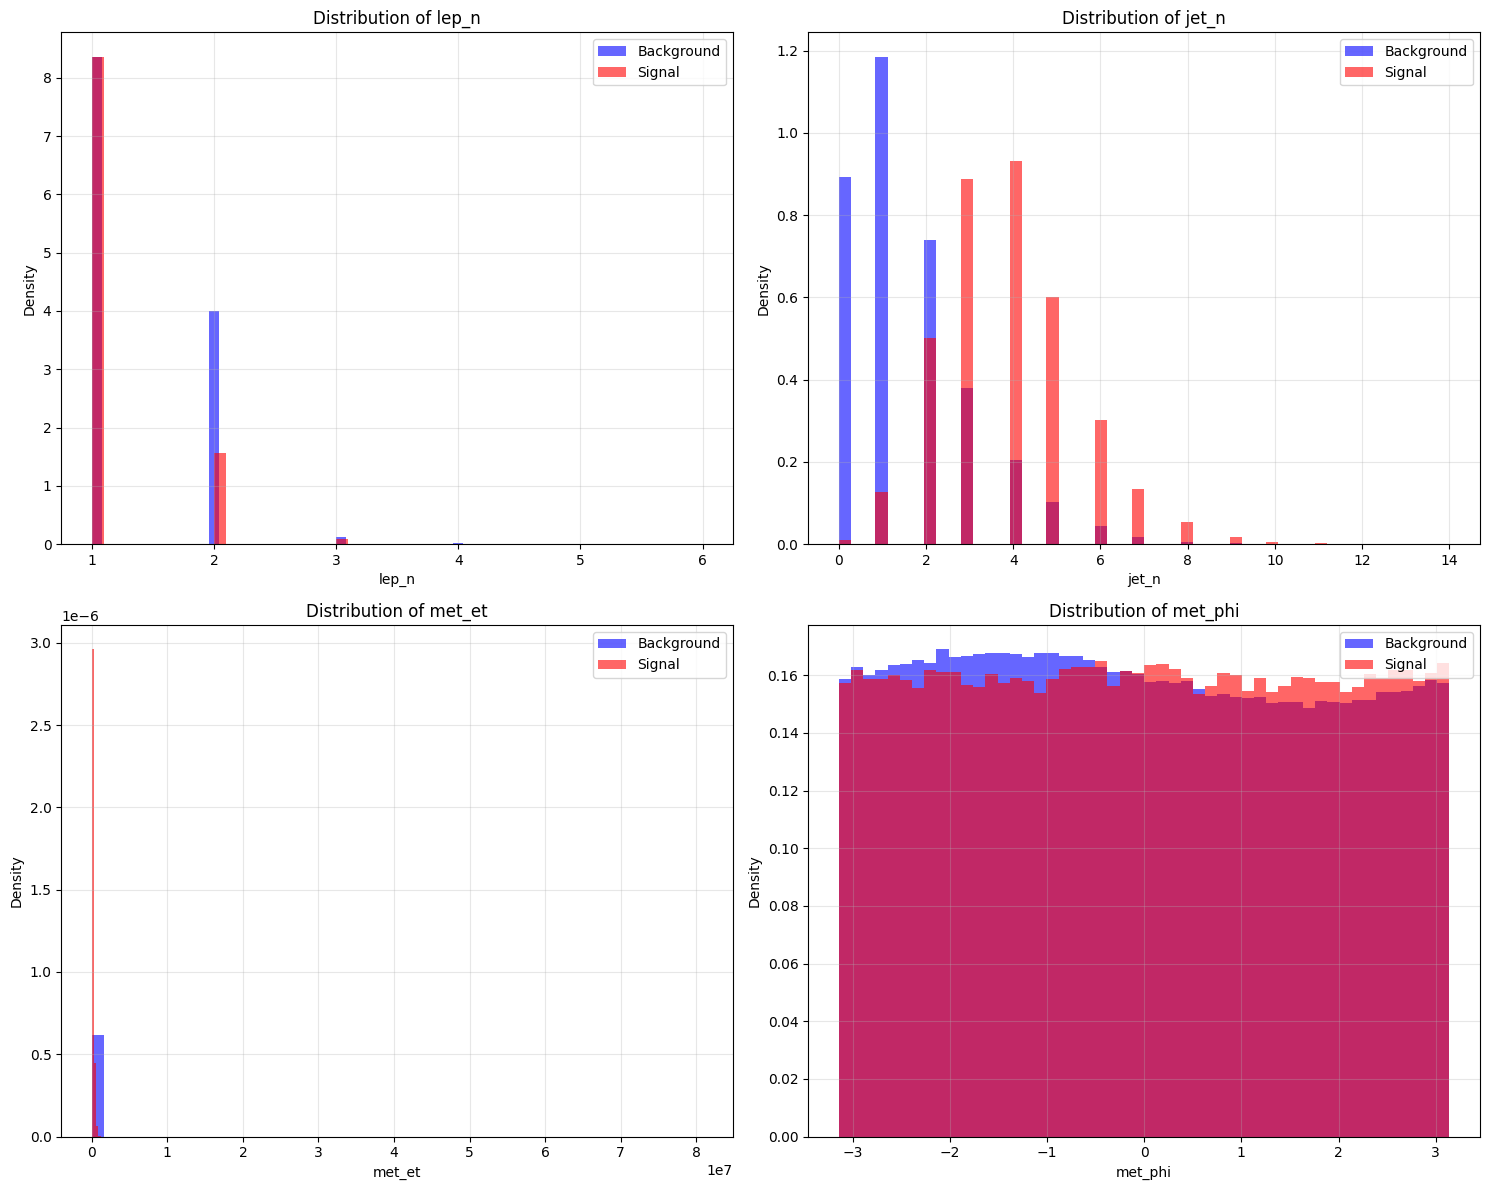

In [ ]:
# Combine datasets for comparative analysis
combined_df_temp = pd.concat([background_df, signal_df], ignore_index=True)

# A comprehensive distribution plot for key physics variables
key_physics_vars = ['lep_n', 'jet_n', 'met_et', 'met_phi']
key_physics_vars = [var for var in key_physics_vars if var in combined_df_temp.columns]

if key_physics_vars:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for i, var in enumerate(key_physics_vars):
        if i < 4:  # Only plot first 4 variables
            axes[i].hist(background_df[var], bins=50, alpha=0.6, label='Background',
                        color='blue', density=True)
            axes[i].hist(signal_df[var], bins=50, alpha=0.6, label='Signal',
                        color='red', density=True)
            axes[i].set_title(f'Distribution of {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Density')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


Since our task is to select features that best describe signal in order to detect it accurately. Here with the distribution plots we can see that the number of reconstructed lepton are nearly `2` for both the signal and background. While for the number of reconstructed jet we can see evident separation, but we can't make a direct approach since we need our model to learn signals features as well background's. Bellow we will tackle different aproach to reduce the dimension of our features.

 #### Feature Engineering and Selection Based on Physics Motivation



 In particle physics, not all recorded variables are equally important for identifying new phenomena. We need to remove features that are:

 1. **Metadata/Administrative**: Run numbers, event numbers, channel numbers - these don't contain physics information

 2. **Monte Carlo specific**: Event weights, scale factors - these are simulation artifacts

 3. **Truth-level information**: True flavor, truth matching - not available in real data and are useless for us

 4. **Trigger information**: May introduce bias and isn't part of the physics signature (these are the scaleFactor)

In [ ]:
# Features to remove based on physics reasoning
features_to_remove = [
    # Trigger and administrative
    'lep_trigMatched',
    'channelNumber',
    'runNumber',
    'data_type',
    'label',
    'eventNumber',

    # Monte Carlo weights and scale factors
    'eventWeight',
    'mcWeight',
    'scaleFactor_BTAG',
    'scaleFactor_ELE',
    'scaleFactor_JVFSF',
    'scaleFactor_MUON',
    'scaleFactor_PILEUP',
    'scaleFactor_TRIGGER',
    'scaleFactor_ZVERTEX',

    # Truth-level information (not available in real data)
    'jet_1_trueflav', 'jet_1_truthMatched',
    'jet_2_trueflav', 'jet_2_truthMatched',
    'jet_3_trueflav', 'jet_3_truthMatched',
    'jet_4_trueflav', 'jet_4_truthMatched',
    'jet_5_trueflav', 'jet_5_truthMatched',
    'jet_6_trueflav', 'jet_6_truthMatched',
    'jet_7_trueflav', 'jet_7_truthMatched',
    'jet_8_trueflav', 'jet_8_truthMatched',
    'jet_9_trueflav', 'jet_9_truthMatched'
]
print('='*200)
print('='*200)
print('='*200)
print(f"Initial features to remove: {len(features_to_remove)}")
print('='*200)


Initial features to remove: 33


#### What Are b-tagging Features and Why Do They Matter?

In particle physics, a "jet" is a spray of particles created when a quark or gluon is produced in a collision. Some jets come from bottom quarks (b-quarks), which are important clues for finding new particles like the Z' boson. "b-tagging" is a technique to identify jets that likely came from a b-quark. The features called 'SV0' and 'MV1' are two different ways to measure this. We compare them to see which one helps our model the most.

#### Analysis of Jet Features with focus on b-tagging variables

An appearance of a bottom quark is a sign that there might be a Z prime in the events. The features that contains these information are 'SV0' and 'MV1'. However these proprieties are somehow related, so we are going to keep only on of them.


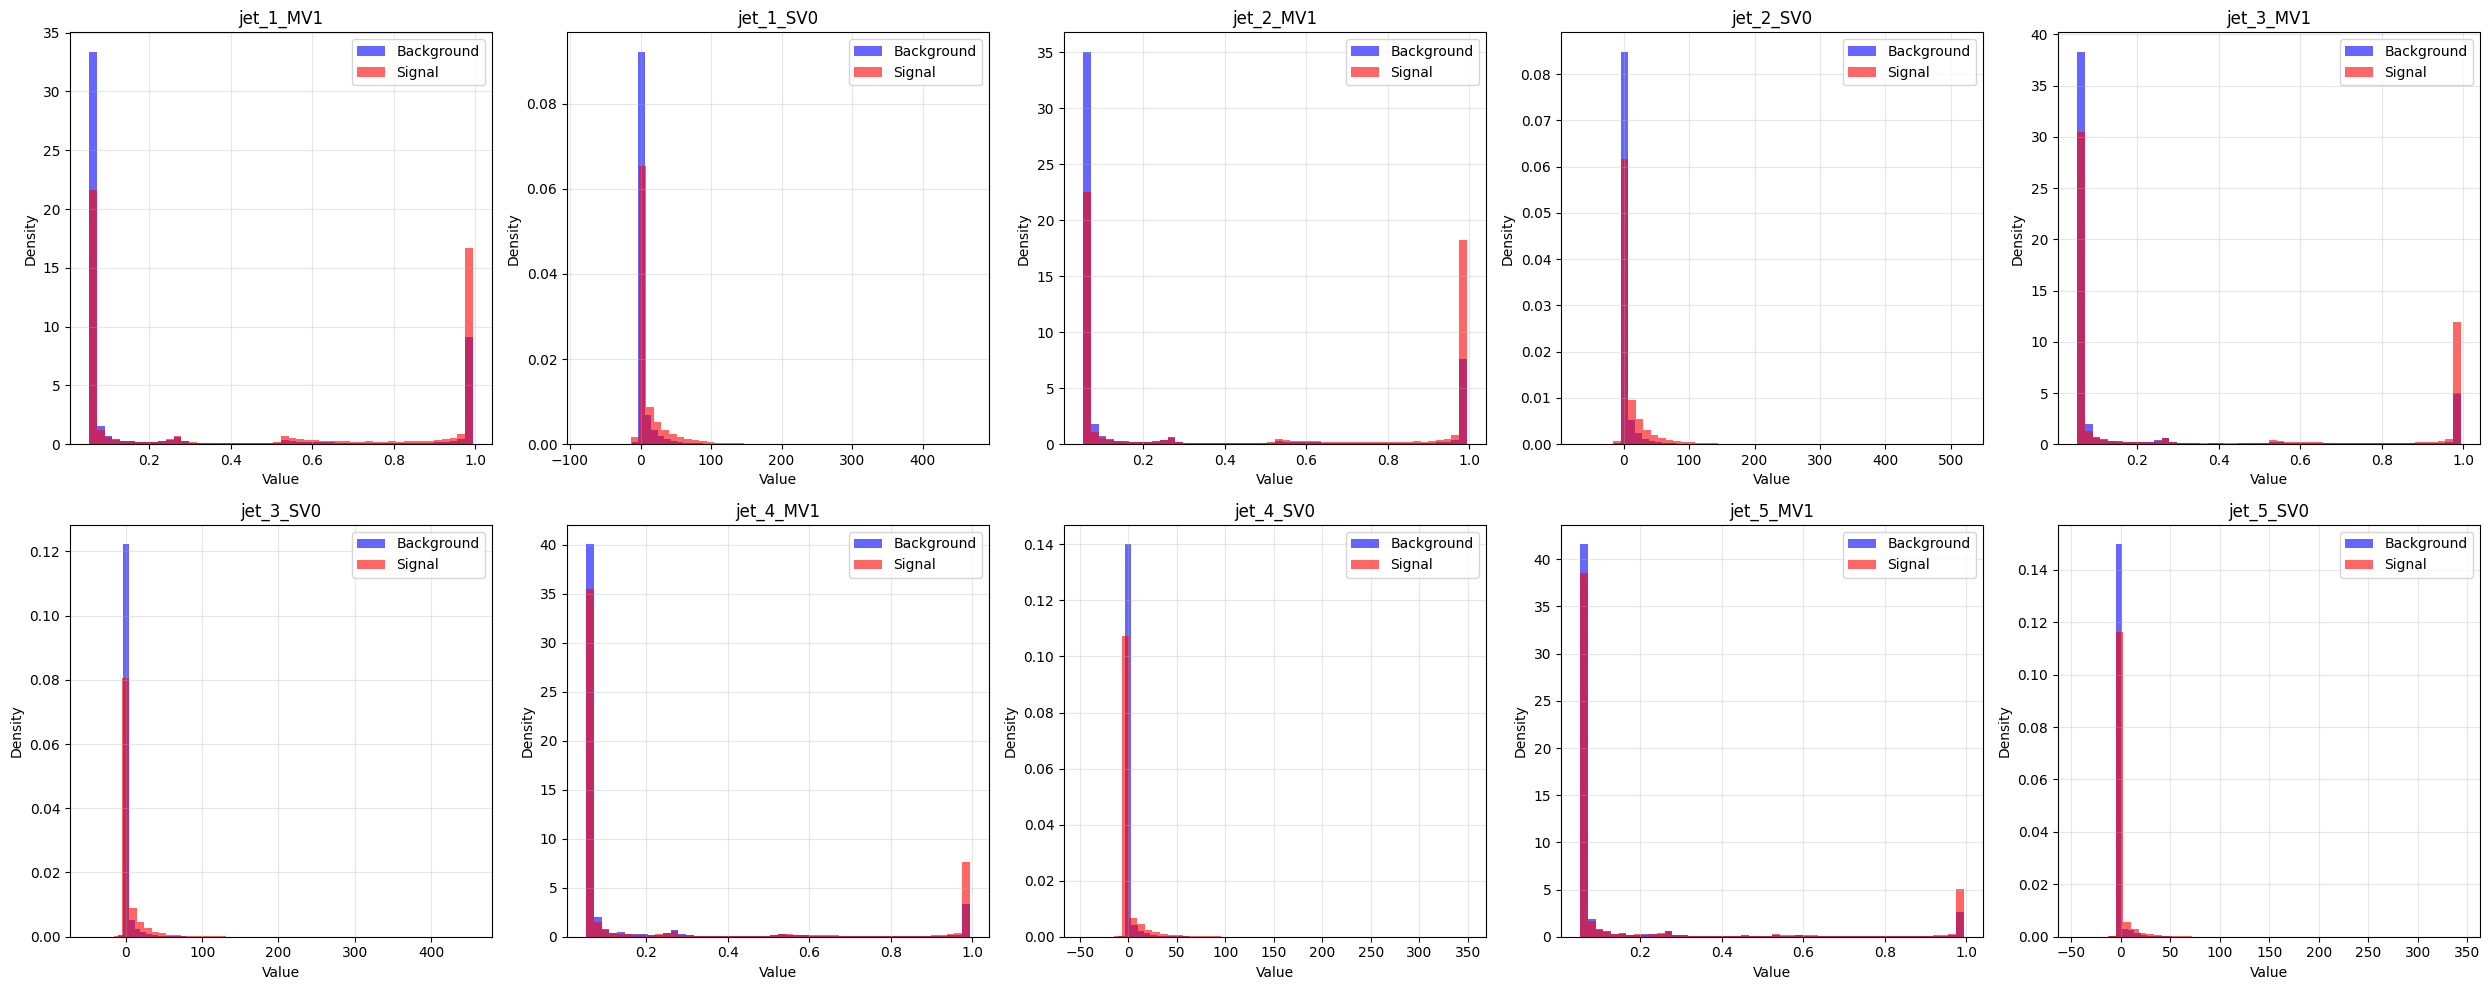

In [ ]:
# Analyze jet features - focus on b-tagging discriminants (SV0, MV1)
jet_features = [f for f in background_df.columns if 'jet_' in f and f not in features_to_remove]

jet_btag_features = [f for f in jet_features if 'SV0' in f or 'MV1' in f]

# Plot b-tagging discriminants for different jet multiplicities
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.ravel()

for i, feature in enumerate(jet_btag_features[:10]):  # Only show first 10 for clarity
    axes[i].hist(background_df[feature], bins=50, alpha=0.6, label='Background',
                color='blue', density=True)
    axes[i].hist(signal_df[feature], bins=50, alpha=0.6, label='Signal',
                color='red', density=True)
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The only difference between them is that 'MV1' has two pic compared to 'SV0' which has only one pic, making it best suitable for classification. So we will discared 'SV0' in benefit of 'MV1'.

In [ ]:
# We found that 'MV1' is a better b-tagging feature than 'SV0' for our analysis.
# So, we remove all 'SV0' features for jets 1 through 9 from our dataset.
features_to_remove.extend([f'jet_{i}_SV0' for i in range(1, 10)])
print('='*200)
print('='*200)
print('='*200)
print('='*200)
print(f"\nAdded {len([f'jet_{i}_SV0' for i in range(1, 10)])} higher-order jet SV0 features to removal list")
print(features_to_remove)


Added 9 higher-order jet SV0 features to removal list
['lep_trigMatched', 'channelNumber', 'runNumber', 'data_type', 'label', 'eventNumber', 'eventWeight', 'mcWeight', 'scaleFactor_BTAG', 'scaleFactor_ELE', 'scaleFactor_JVFSF', 'scaleFactor_MUON', 'scaleFactor_PILEUP', 'scaleFactor_TRIGGER', 'scaleFactor_ZVERTEX', 'jet_1_trueflav', 'jet_1_truthMatched', 'jet_2_trueflav', 'jet_2_truthMatched', 'jet_3_trueflav', 'jet_3_truthMatched', 'jet_4_trueflav', 'jet_4_truthMatched', 'jet_5_trueflav', 'jet_5_truthMatched', 'jet_6_trueflav', 'jet_6_truthMatched', 'jet_7_trueflav', 'jet_7_truthMatched', 'jet_8_trueflav', 'jet_8_truthMatched', 'jet_9_trueflav', 'jet_9_truthMatched', 'jet_1_SV0', 'jet_2_SV0', 'jet_3_SV0', 'jet_4_SV0', 'jet_5_SV0', 'jet_6_SV0', 'jet_7_SV0', 'jet_8_SV0', 'jet_9_SV0']


#### Lepton Feature Analysis


Leptons (like electrons and muons) are important because they are often produced when a Z' boson decays. By looking at how many leptons are in each event, and their properties, we can find patterns that help us tell signal from background. We focus on the first two leptons in each event, since most interesting events have one or two leptons.

 In our Z' → tt̄ analysis, we expect events to be characterized primarily by the decay products of the top quarks. Most events should have a well-defined lepton multiplicity, typically 1-2 leptons from W boson decays.

/tmp/ipython-input-104-2847818790.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='lep_n', data=combined_df_temp, palette='Set2')


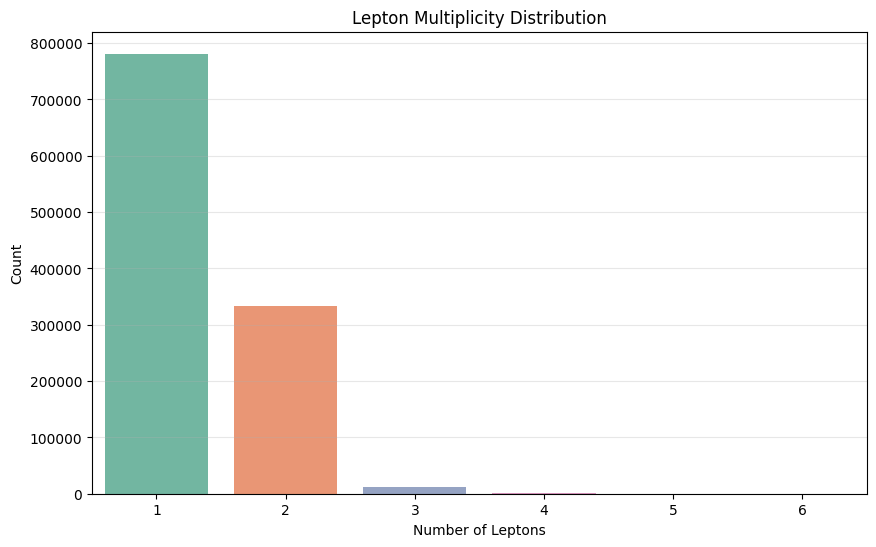

In [ ]:
# Let's look at how many leptons (electrons or muons) are in each event.
# Most signal and background events have 1 or 2 leptons. This helps us focus on the most relevant cases.
lep_features = [f for f in background_df.columns if 'lep_' in f and f not in features_to_remove]

# Plot the distribution of lepton multiplicity
plt.figure(figsize=(10, 6))
sns.countplot(x='lep_n', data=combined_df_temp, palette='Set2')
plt.title('Lepton Multiplicity Distribution')
plt.xlabel('Number of Leptons')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


We can see here clearly again that the number of reconstructed lepton lep_n in each event are wether 1 or 2. There are few events that have 3 lepton, we can ignore these higher lepton and focus only on the 2 leading leptons for simplicity.

In [ ]:
# We keep only the features for the first two leptons, since most events have 1 or 2.
# This reduces noise and focuses on the most important information.
lep_keep = [f for f in lep_features if any(f'_{i}_' in f for i in [1, 2])]
# Always keep the total number of leptons as well
lep_keep.append('lep_n')

lep_to_exclude = [f for f in lep_features if f not in lep_keep]


In [ ]:
# Add the lepton features we don't need to our removal list
features_to_remove.extend(lep_to_exclude)
print('='*200)
print(f"Lepton features to keep: {len(lep_keep)}")
print('='*200)
print('='*200)
print(f"Lepton features to remove: {len(lep_to_exclude)}")
print('='*200)
print('='*200)
print(f"List of lepton features to remove: {(lep_keep)}")


Lepton features to keep: 25
Lepton features to remove: 36
List of lepton features to remove: ['lep_1_E', 'lep_1_charge', 'lep_1_eta', 'lep_1_etcone20', 'lep_1_flag', 'lep_1_phi', 'lep_1_pt', 'lep_1_ptcone30', 'lep_1_trackd0pvunbiased', 'lep_1_tracksigd0pvunbiased', 'lep_1_type', 'lep_1_z0', 'lep_2_E', 'lep_2_charge', 'lep_2_eta', 'lep_2_etcone20', 'lep_2_flag', 'lep_2_phi', 'lep_2_pt', 'lep_2_ptcone30', 'lep_2_trackd0pvunbiased', 'lep_2_tracksigd0pvunbiased', 'lep_2_type', 'lep_2_z0', 'lep_n']


 #### Correlation Analysis of Selected Features

In [ ]:
# Remove the identified features and create the cleaned dataset
all_features_to_remove = list(set(features_to_remove))
print('='*200)
print('='*200)
print(f"Total features to remove: {len(all_features_to_remove)}")


Total features to remove: 78


#### Cleaning Up the Dataset for Modeling

Now that we've identified which features (variables) are not useful for our analysis, we remove them from our dataset. This step helps our machine learning model focus only on the most important information, making it more accurate and easier to interpret. After this, we'll check how many features remain and make sure our data is ready for the next steps.

In [ ]:
# Remove all the features we identified as unhelpful
combined_clean = combined_df_temp.drop(columns=all_features_to_remove, errors='ignore')
# Free up memory by deleting the large original dataframes

del combined_df_temp, background_df, signal_df
gc.collect()
print(f"Features remaining: {len(combined_clean.columns)}")



Features remaining: 95


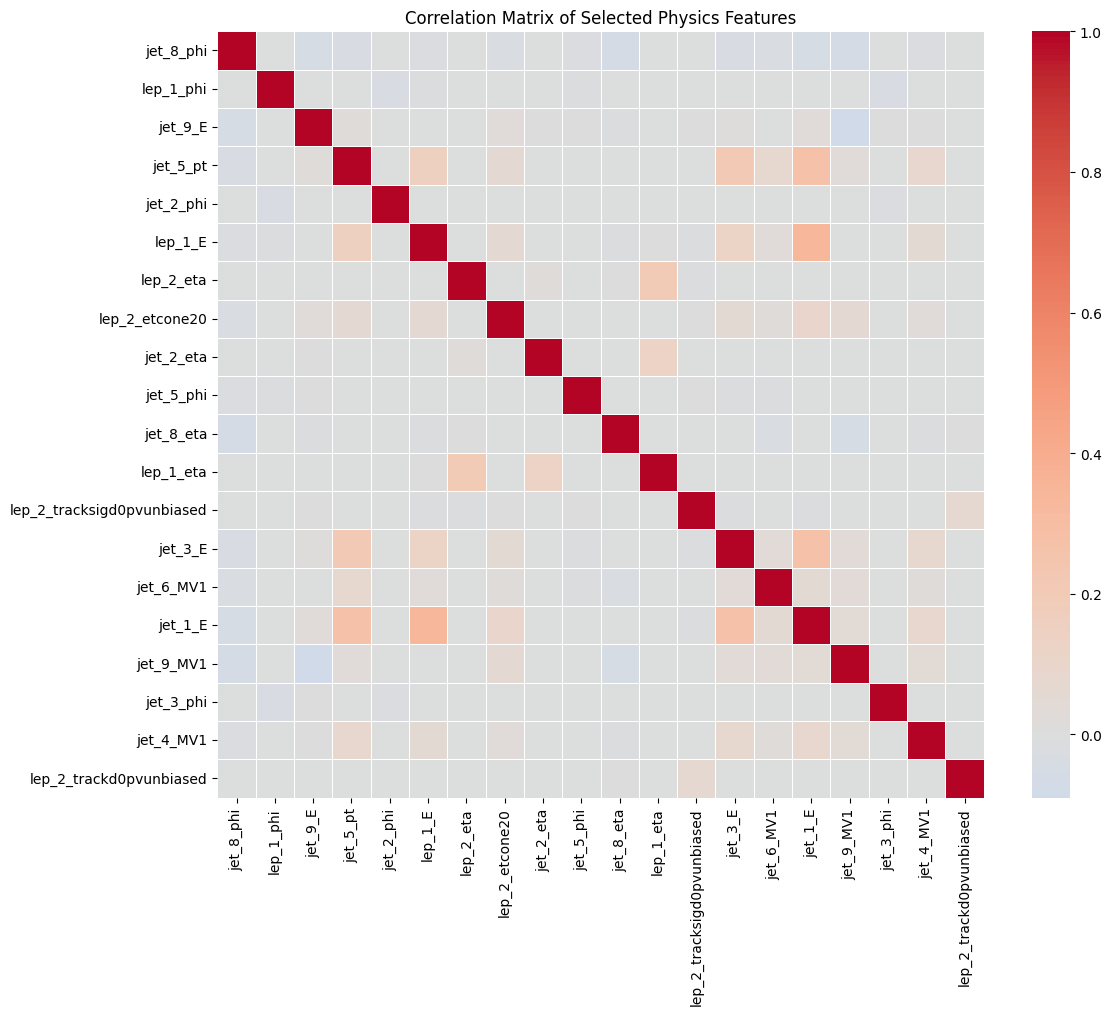

In [ ]:

# Correlation analysis on a subset of features
numeric_features = combined_clean.select_dtypes(include=[np.number]).columns
numeric_features = [f for f in numeric_features if f != 'status']

# Sample features for correlation analysis
if len(numeric_features) > 20:
    sample_features = np.random.choice(numeric_features, 20, replace=False)
else:
    sample_features = numeric_features

# Calculate and plot correlation matrix
correlation_matrix = combined_clean[sample_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Selected Physics Features')
plt.tight_layout()
plt.show()


From the plot notice that our varibales almost have no correlation which is good for our analysis and our modeling. We will make a distrubition plots for the remaining features to detect if some varibales are constant and does not help for distinguishing the signal from the background.

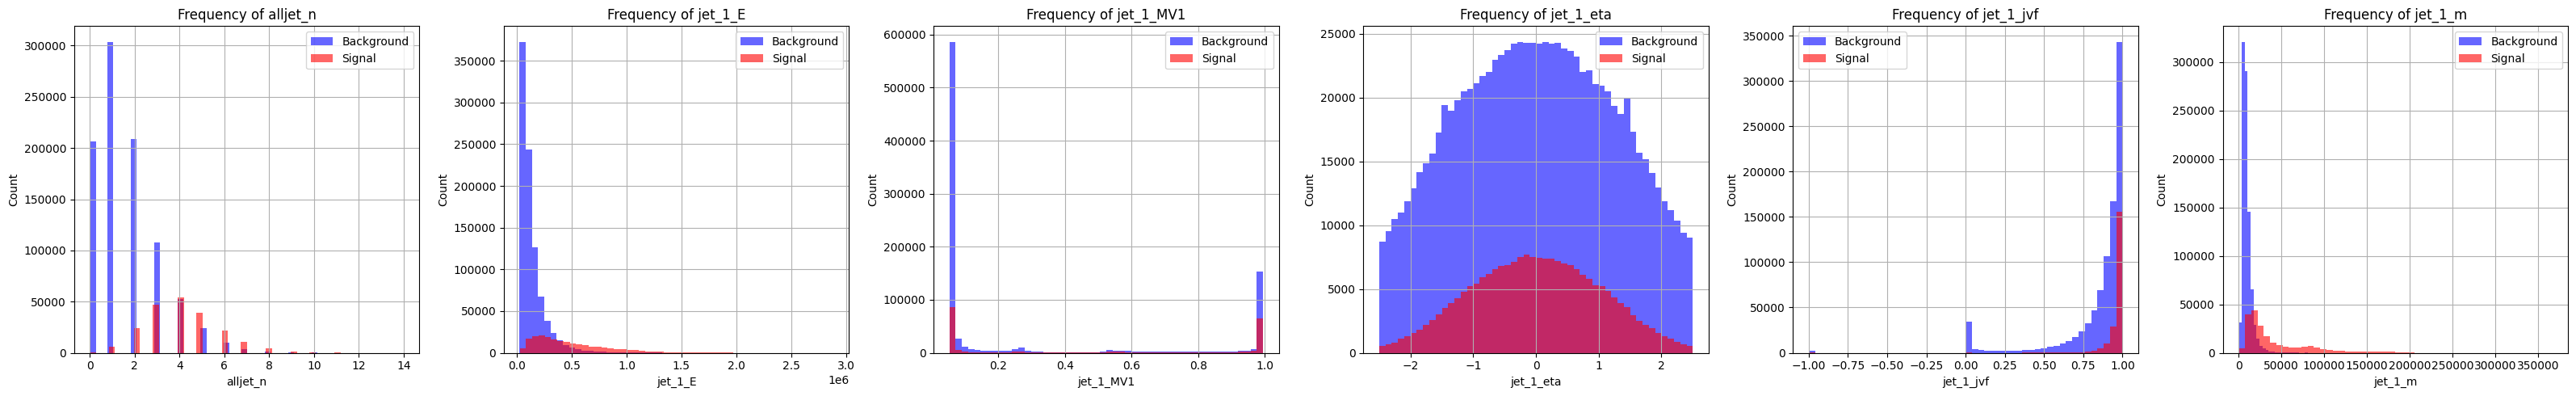

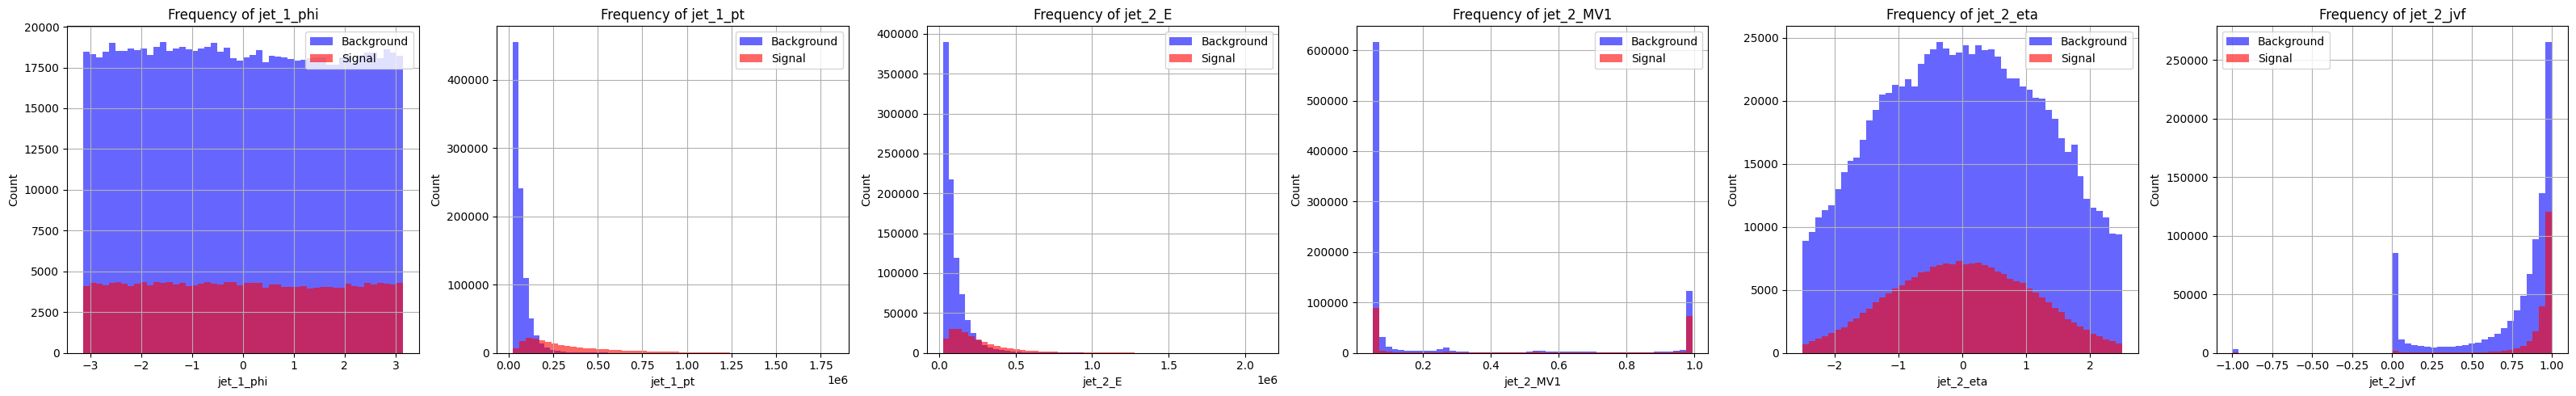

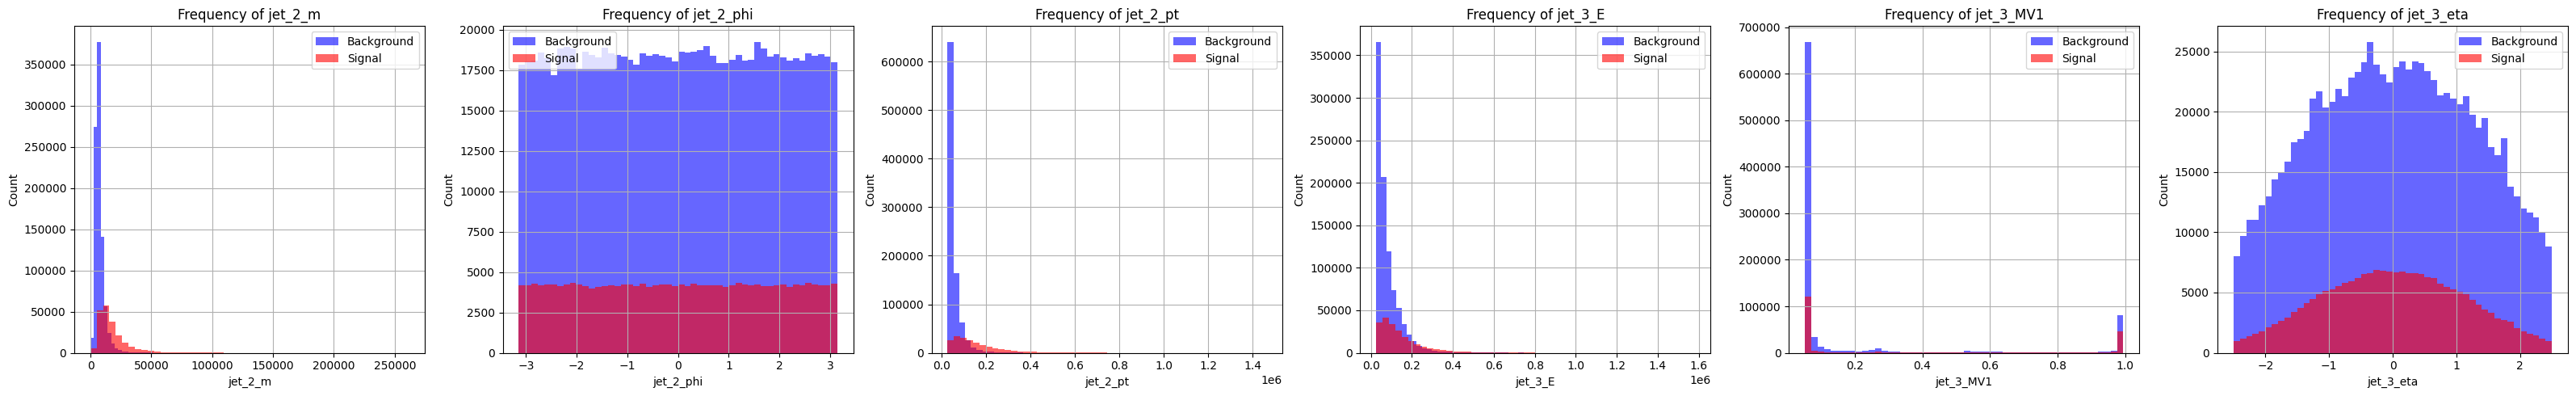

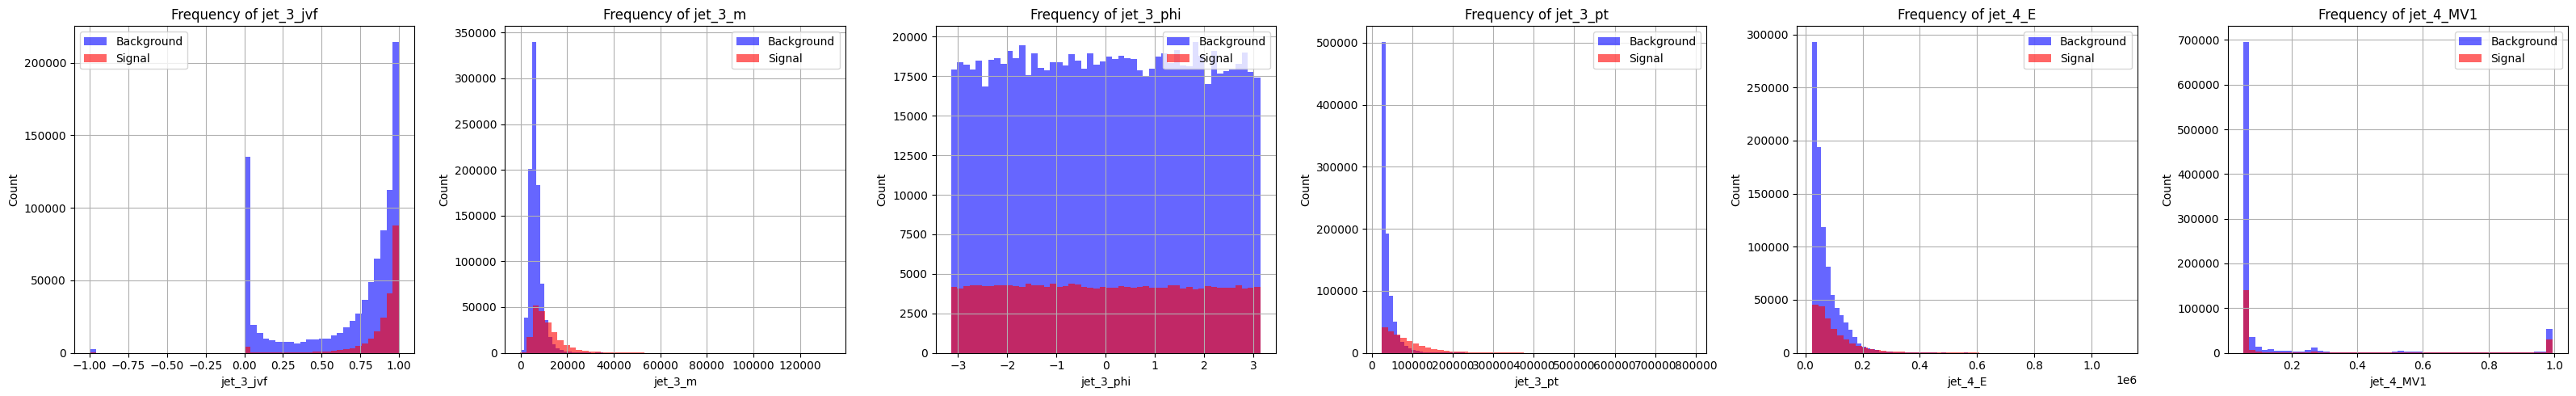

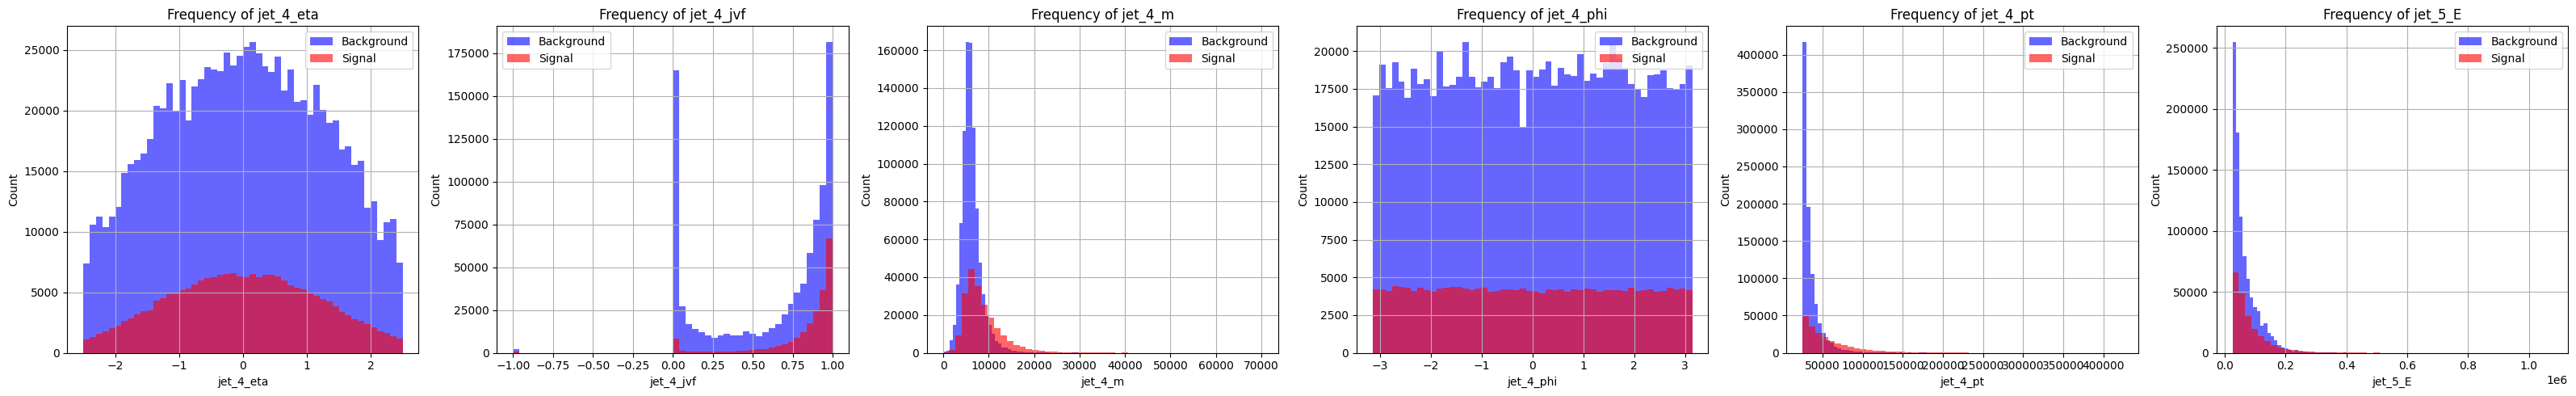

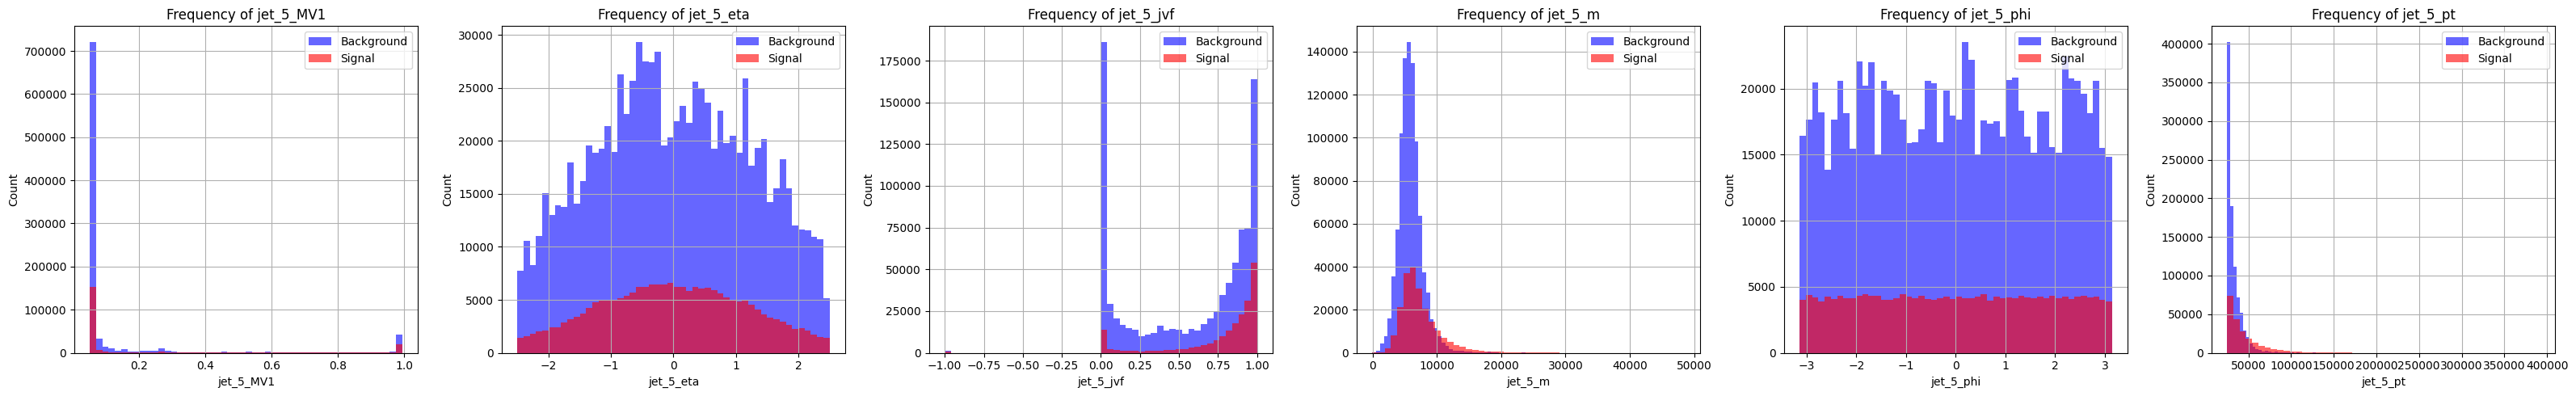

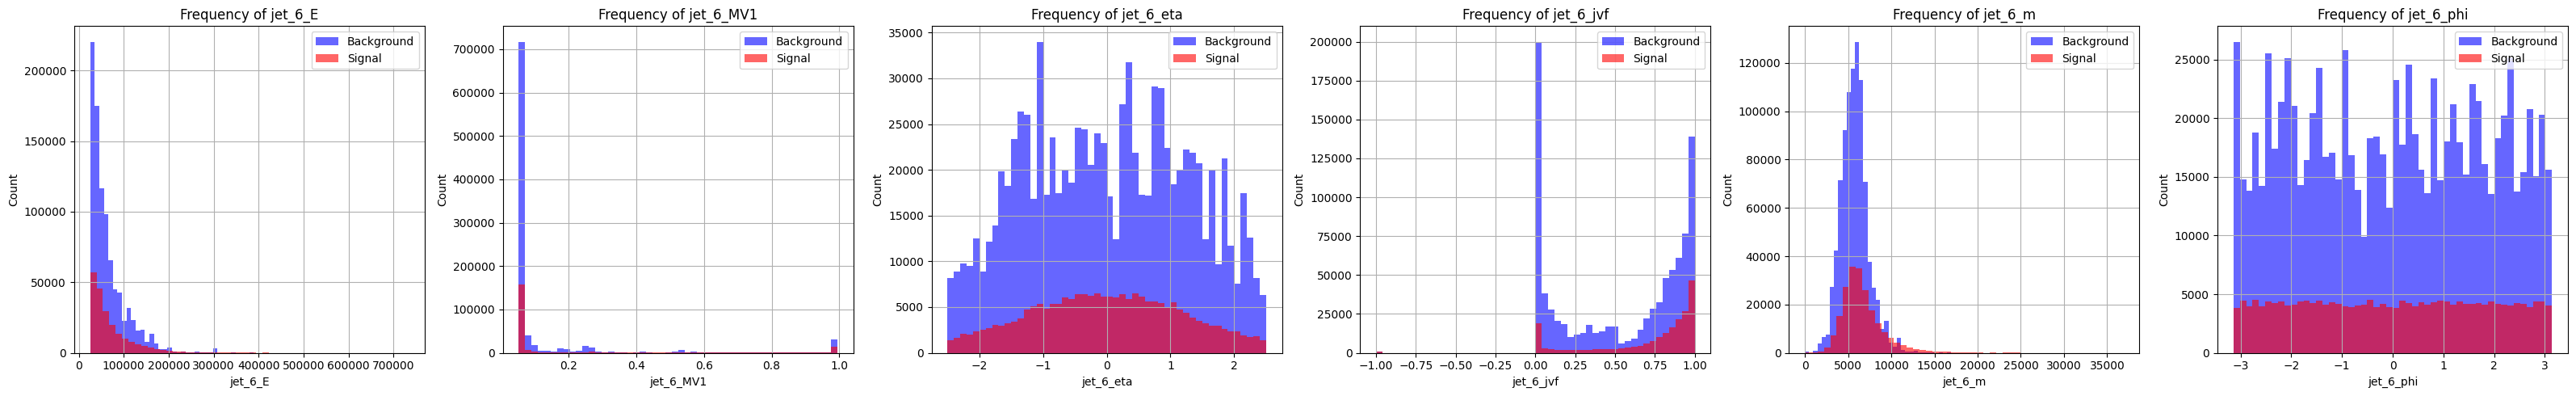

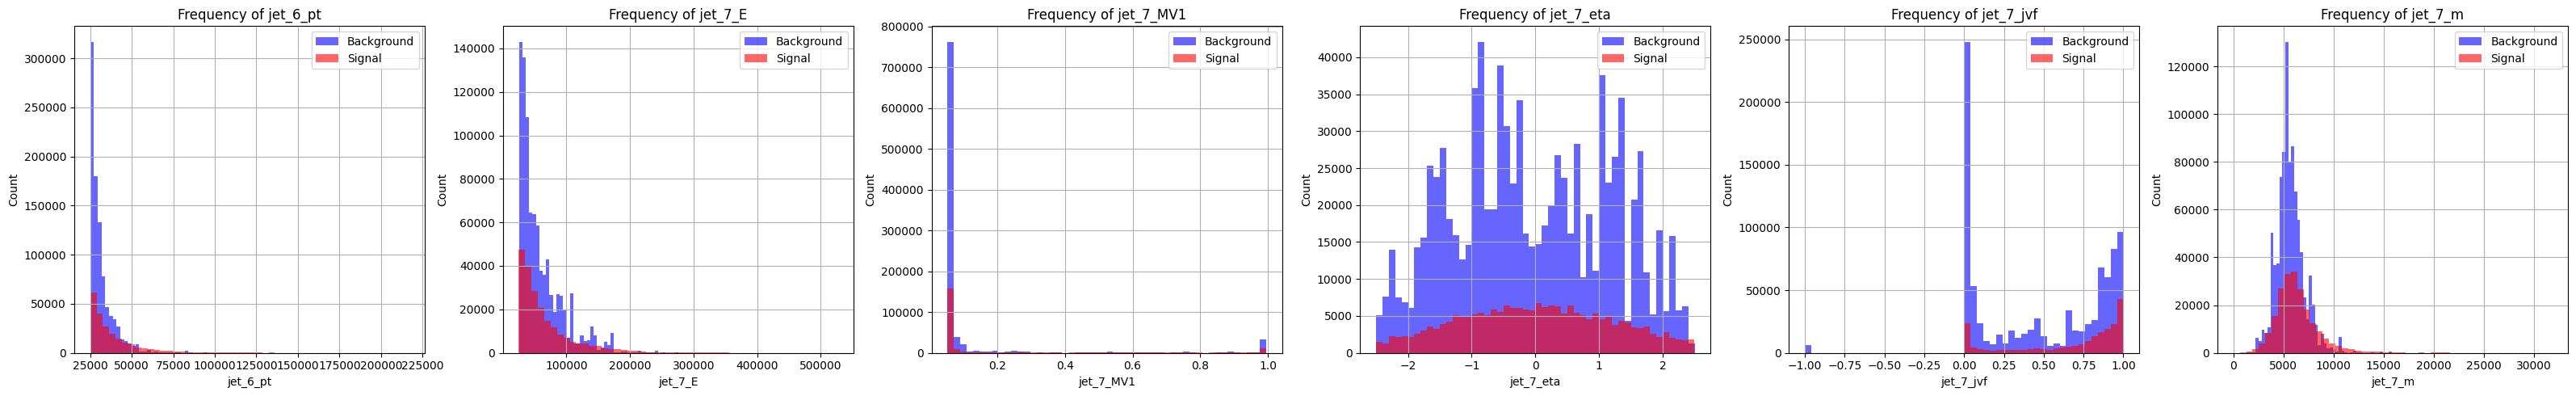

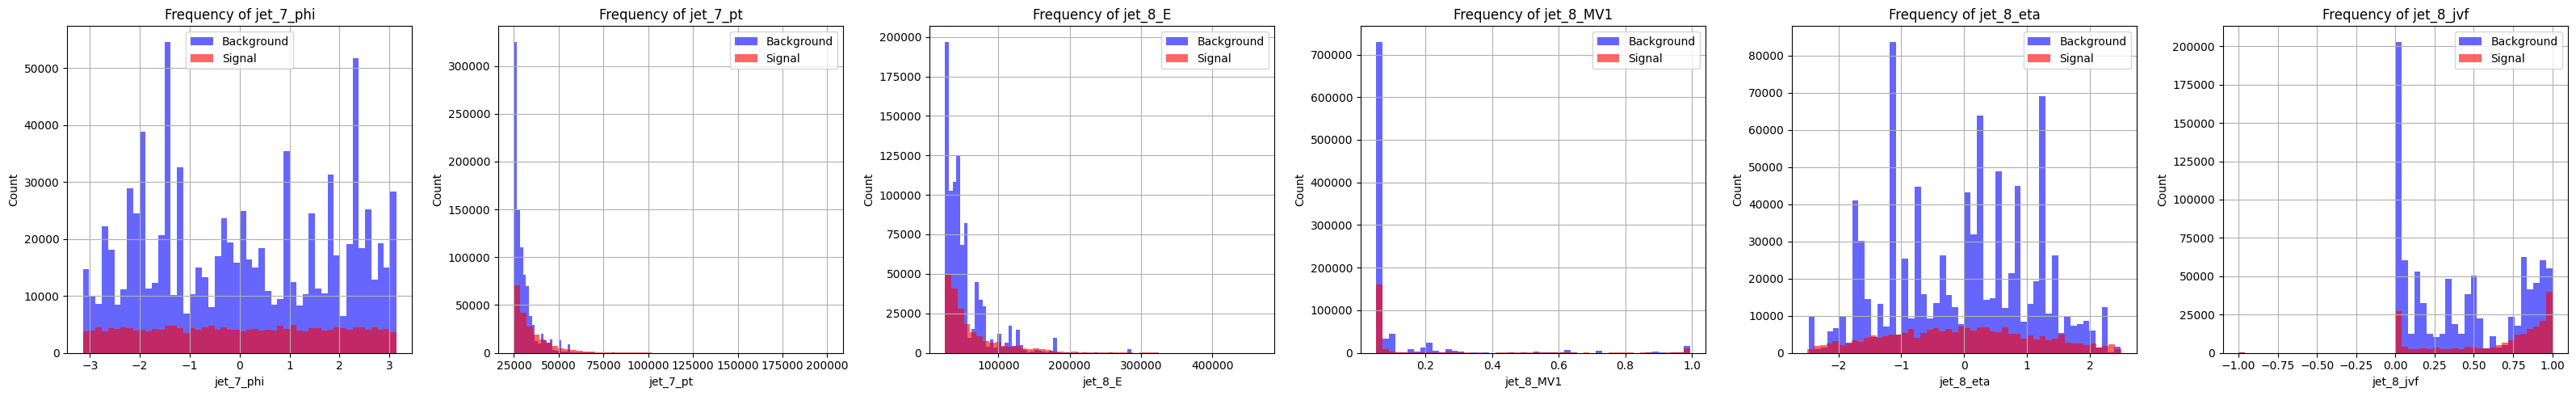

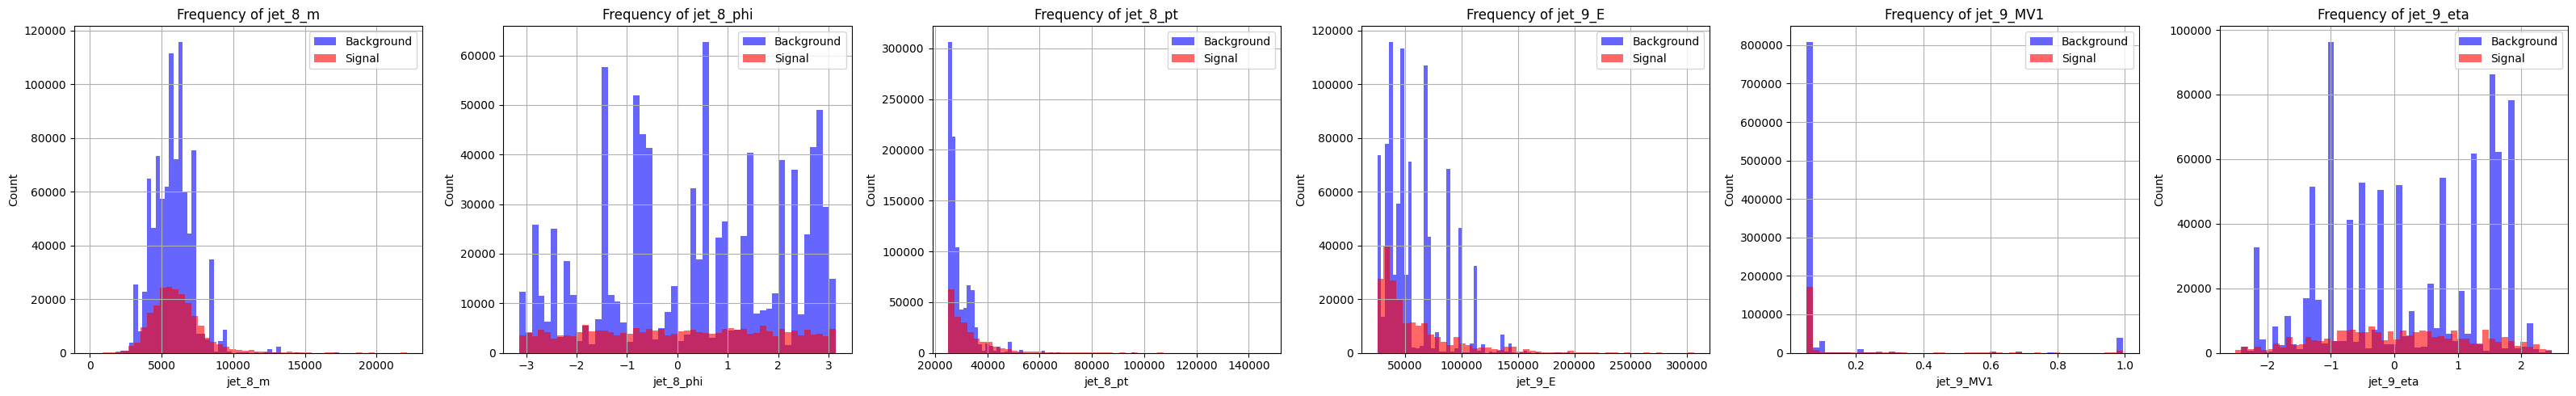

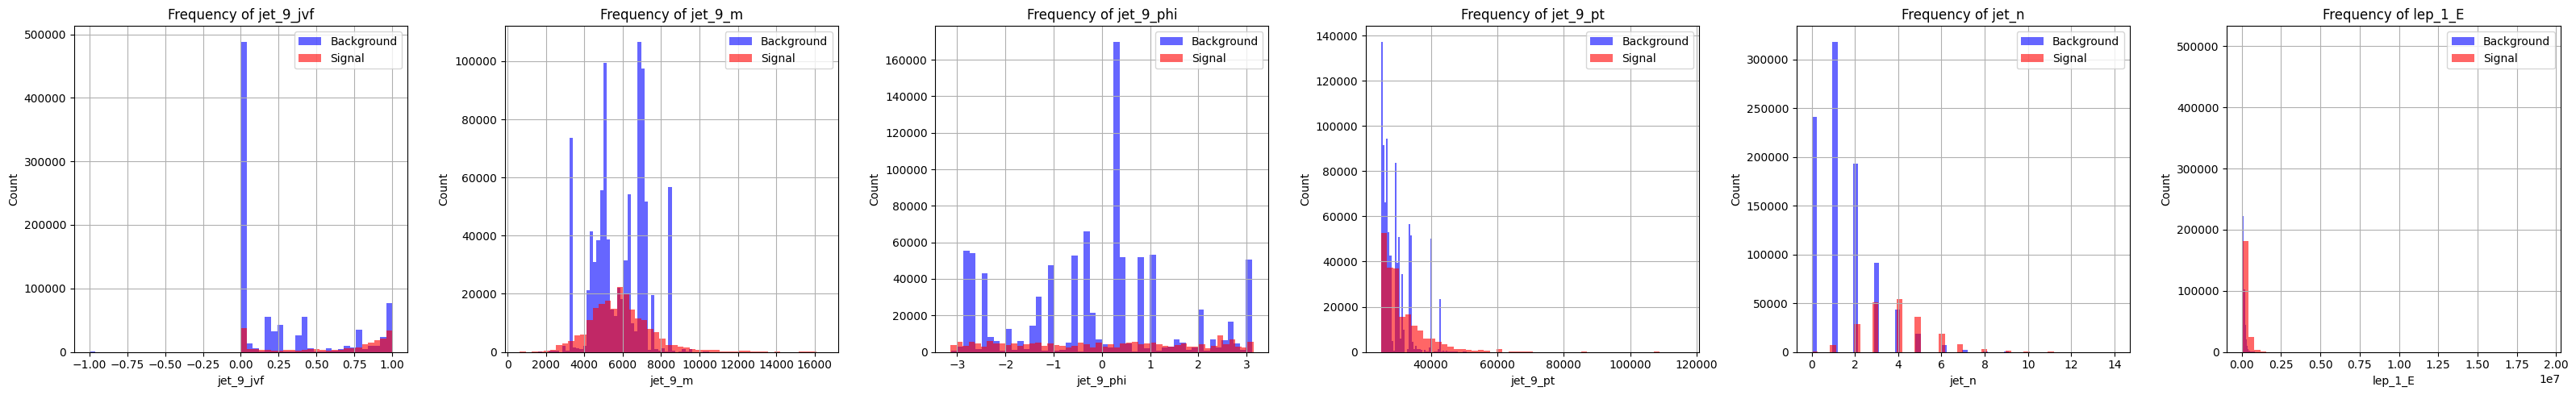

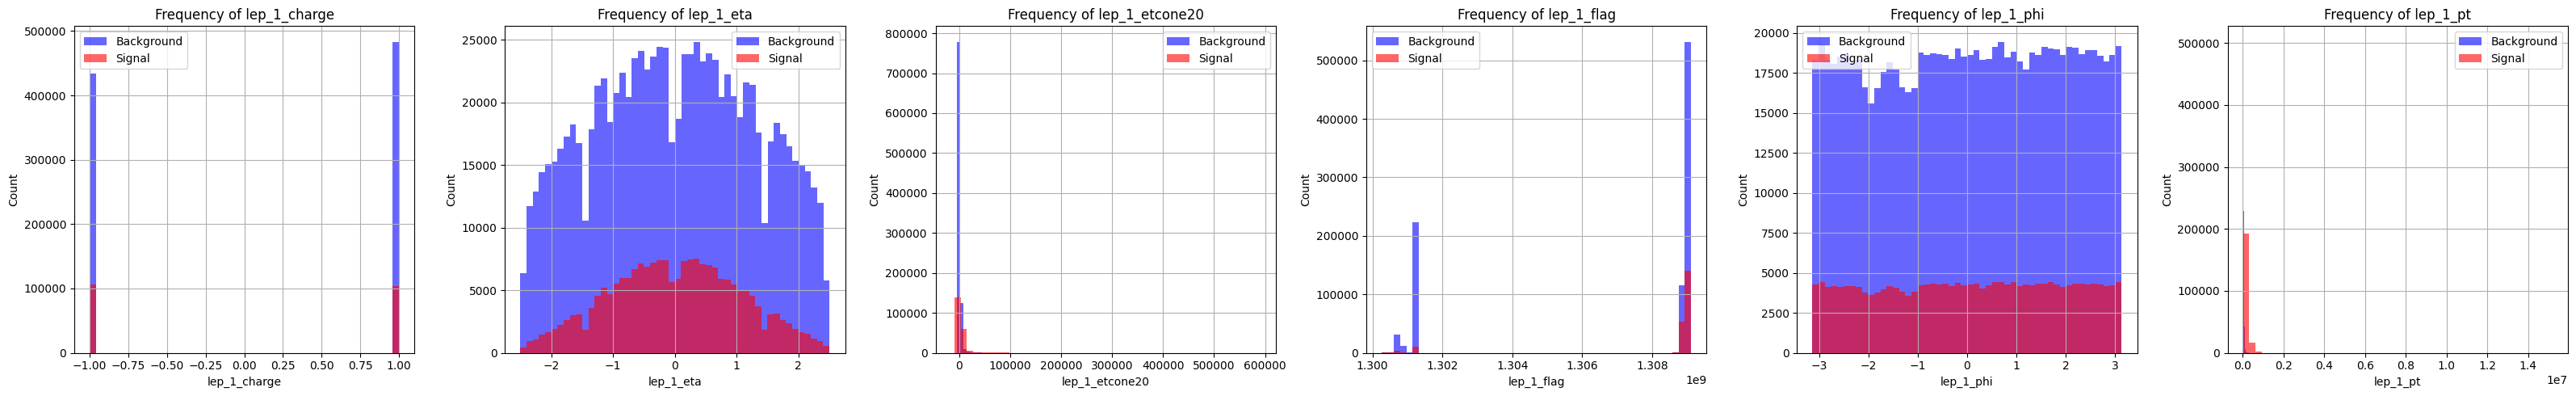

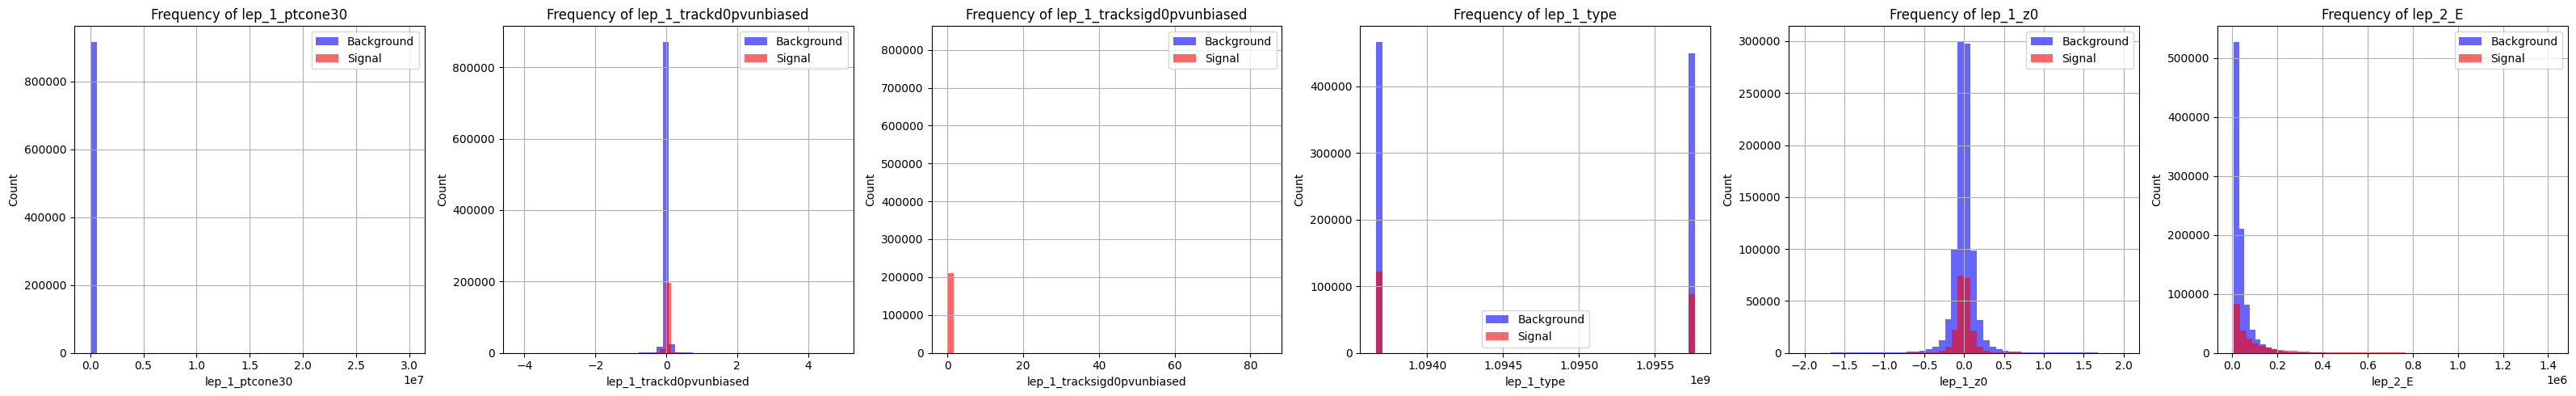

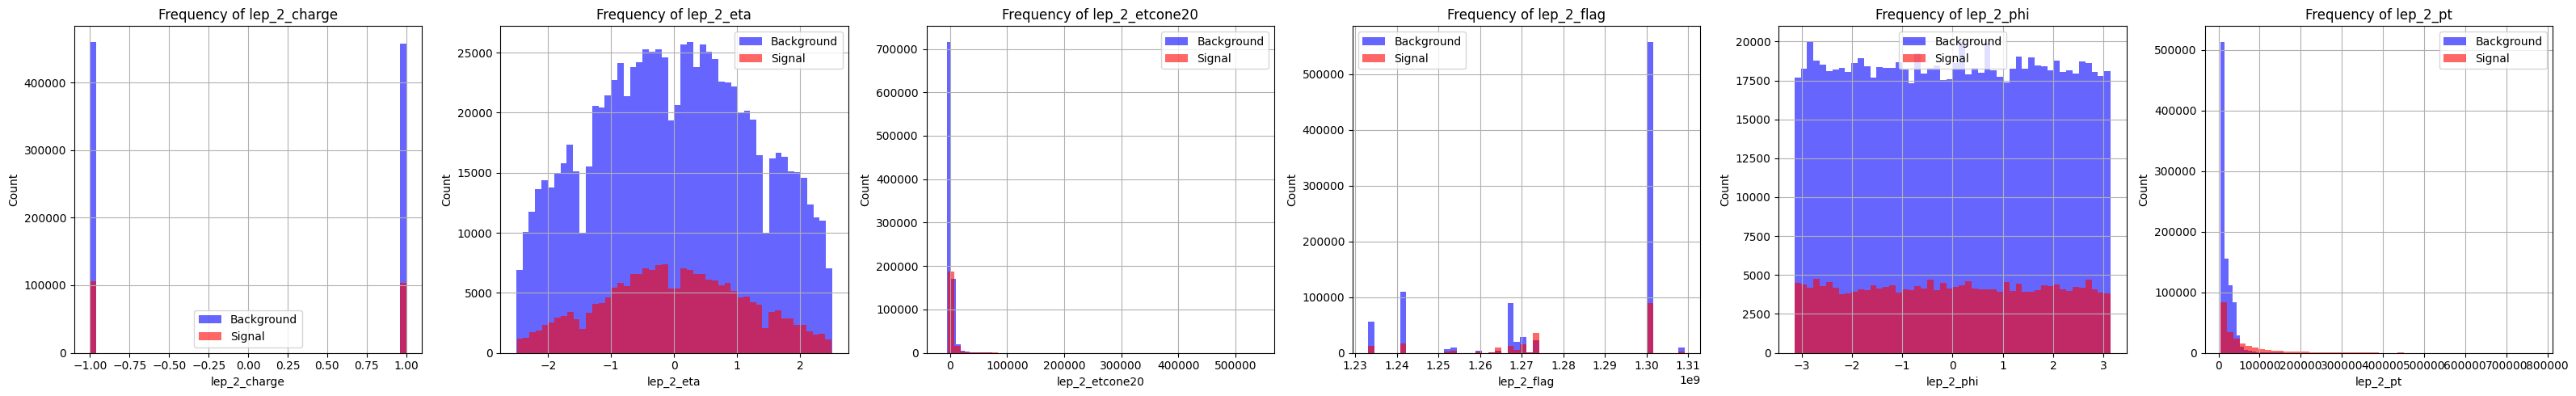

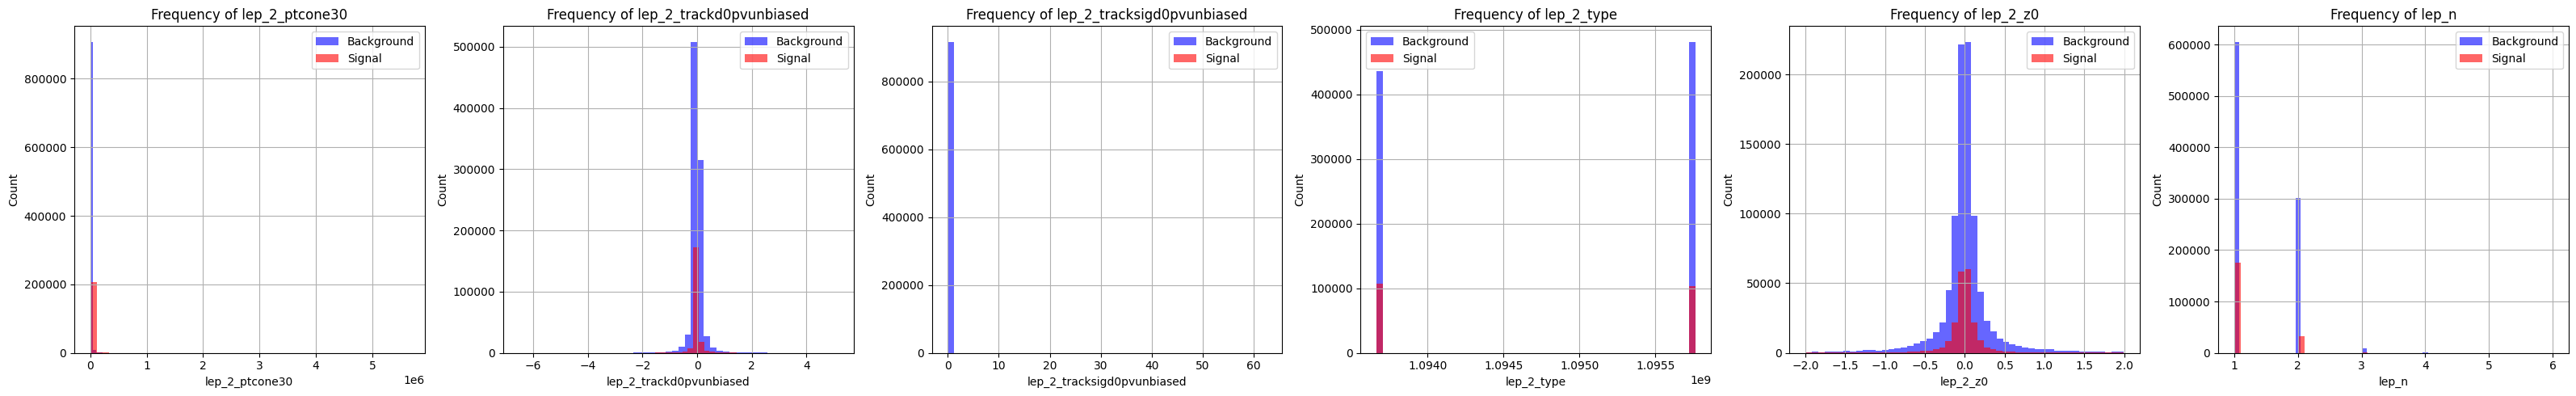

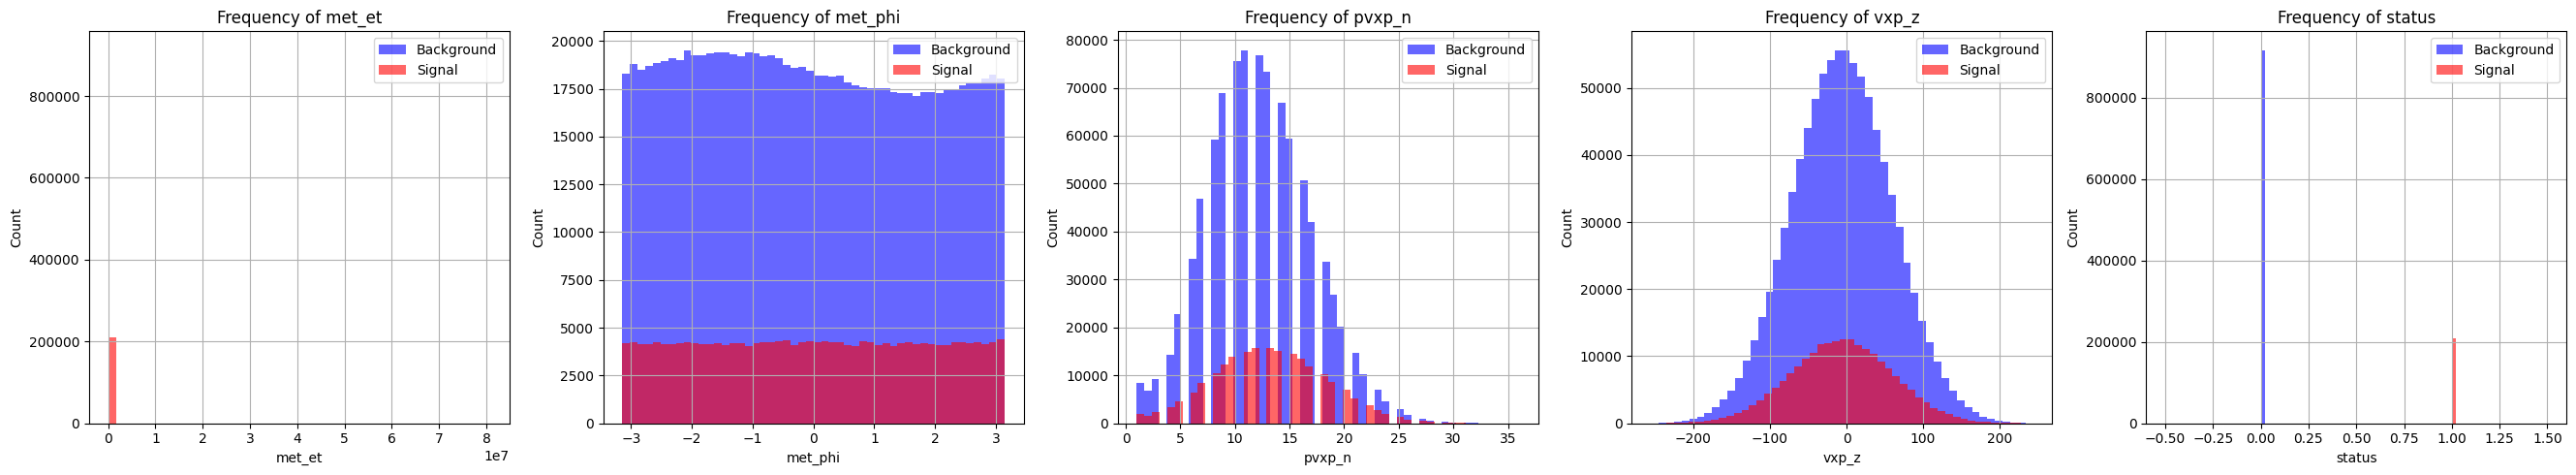

In [ ]:

# Sample features

sample_features = combined_clean.columns

# Plotting the distributions with overlay
for i in range(0, len(sample_features), 6):
    plt.figure(figsize=(32, 5))
    for j in range(6):
        if i + j < len(sample_features):
            feature = sample_features[i + j]
            plt.subplot(1, 6, j + 1)
            plt.hist(combined_clean[combined_clean['status']==0][feature], bins=50, alpha=0.6, label='Background', color='blue', density=False)
            plt.hist(combined_clean[combined_clean['status']==1][feature], bins=50, alpha=0.6, label='Signal', color='red', density=False)
            plt.title(f'Frequency of {feature}')
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.legend()
            plt.grid()
    plt.tight_layout()
    plt.show()

To avoid overfitting for our modeling, we will again discard features that has only one value. That is too say that can added bias to our model and make it learn nothing but just to memorize their values, these features are : 'lep_1_tracksigd0pvunbiased', 'lep_2_tracksigd0pvunbiased'.And the redundacy of 'all_jet and jet_n also', so we will keep only 'jet_n'

In [ ]:
# Remove features that have only one value (constant) or are redundant.
# Constant features don't help the model learn, and redundant features can add noise.

new_features_to_remove = ['lep_1_tracksigd0pvunbiased', 'lep_2_tracksigd0pvunbiased', 'alljet_n']
print('='*200)
print(f"3 New features to remove : {new_features_to_remove}")
all_features_to_remove.extend(new_features_to_remove)
print(f"{len(all_features_to_remove)} to remove.")
print('='*200)
print('='*200)
combined_clean = combined_clean.drop(columns=new_features_to_remove, errors='ignore')

3 New features to remove : ['lep_1_tracksigd0pvunbiased', 'lep_2_tracksigd0pvunbiased', 'alljet_n']
81 to remove.


 #### Class Balance Analysis

 From the dataset list we can see already that there are few signal than there were background but we are going to investigate this imbalance visually.

=== CLASS BALANCE ANALYSIS ===
Background events: 917556 (81.4%)
Signal events: 209465 (18.6%)
Total events: 1127021


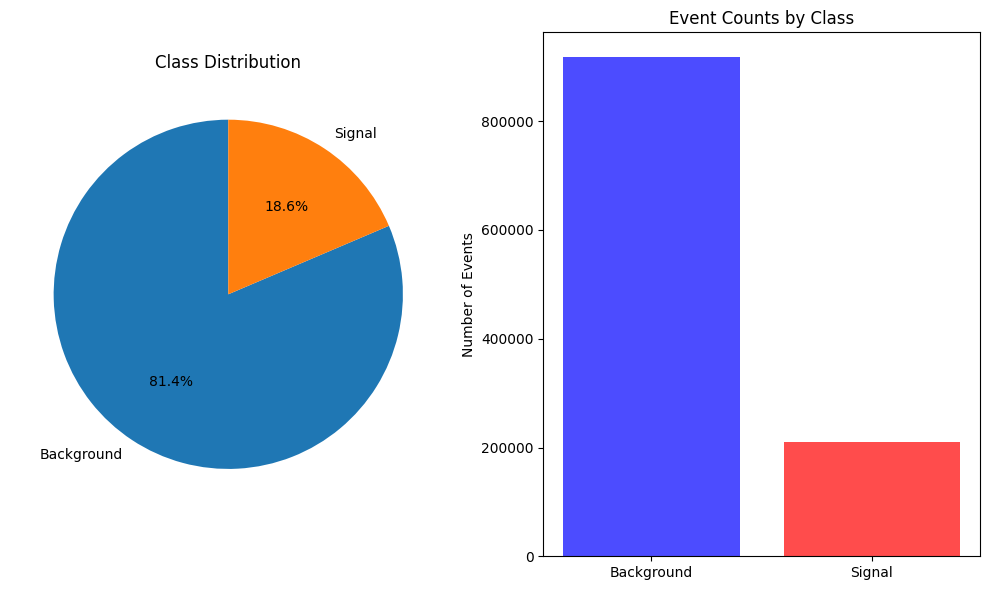

Imbalance ratio: 4.38


In [ ]:
# Analyze class balance in the dataset
print("=== CLASS BALANCE ANALYSIS ===")

# Count events by class
bg_count = len(combined_clean[combined_clean['status']==0])
sig_count = len(combined_clean[combined_clean['status']==1])
total_count = bg_count + sig_count

print(f"Background events: {bg_count} ({bg_count/total_count*100:.1f}%)")
print(f"Signal events: {sig_count} ({sig_count/total_count*100:.1f}%)")
print(f"Total events: {total_count}")

# Visualize class balance using pir and bar plot
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.pie([bg_count, sig_count], labels=['Background', 'Signal'],
        autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')

plt.subplot(1, 2, 2)
plt.bar(['Background', 'Signal'], [bg_count, sig_count],
        color=['blue', 'red'], alpha=0.7)
plt.title('Event Counts by Class')
plt.ylabel('Number of Events')

plt.tight_layout()
plt.show()

# Check if we need to address class imbalance
imbalance_ratio = max(bg_count, sig_count) / min(bg_count, sig_count)
print(f"Imbalance ratio: {imbalance_ratio:.2f}")



The imbalance ration is quite high, and it is quite obvious that there are many background events, this is confirmed and admitted that in the real process signal event are rare. Nevertheles for us to train a classifier or or to use machine learning we need to balance the dataset so that our model won't make make mistake for classifiyng.

 ### Modeling/Analysis

 #### Data Preparation for Machine Learning with imbalance taken in account

In [ ]:
# Prepare the final dataset for machine learning
print("=== PREPARING DATA FOR MACHINE LEARNING ===")

# Split the data into training and validation sets
# Training set: used to teach the model
# Validation set: used to test how well the model works on new data
X_train, X_val, y_train, y_val = train_test_split(combined_clean.drop(columns=['status']), combined_clean['status'], test_size=0.2,
                                                  random_state=42, stratify=combined_clean['status'])

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Validation class distribution: {np.bincount(y_val)}")


=== PREPARING DATA FOR MACHINE LEARNING ===

Training set: 901616 samples
Validation set: 225405 samples
Training class distribution: [734044 167572]
Validation class distribution: [183512  41893]


 #### Random Forest Classifier Training

In [ ]:
# Now we train a Random Forest classifier, a popular machine learning model.
# It works by building many decision trees and combining their results for better accuracy.
# We use special settings to help with class imbalance and avoid overfitting.

print("=== TRAINING RANDOM FOREST CLASSIFIER ===")


# Initialize the Random Forest Classifier with warm_start
rf_classifier = RandomForestClassifier(n_estimators=1, warm_start=True, random_state=42)

# Train the model on the training data
print("Training Random Forest...")
n_estimators = 100
for i in tqdm(range(1, n_estimators + 1), desc="Fitting Random Forest"):
    rf_classifier.fit(X_train, y_train)



# Make predictions on the validation set
# y_val_pred: predicted class (signal/background)
# y_val_proba: predicted probability of being signal
y_val_pred = rf_classifier.predict(X_val)
y_val_proba = rf_classifier.predict_proba(X_val)[:, 1]

print("Training completed!")


=== TRAINING RANDOM FOREST CLASSIFIER ===
Training Random Forest...


Fitting Random Forest:   1%|          | 1/100 [00:16<27:42, 16.79s/it]/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:466: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
Fitting Random Forest:   2%|▏         | 2/100 [00:17<11:38,  7.13s/it]/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:466: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
Fitting Random Forest:   3%|▎         | 3/100 [00:17<06:31,  4.04s/it]/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:466: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
Fitting Random Forest:   4%|▍         | 4/100 [00:17<04:08,  2.58s/it]/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:466: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
Fitting Random Forest:   5%|▌         | 5/10

Training completed!


 #### Model Performance Evaluation

=== MODEL PERFORMANCE EVALUATION ===
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96    183512
           1       0.82      0.81      0.82     41893

    accuracy                           0.93    225405
   macro avg       0.89      0.89      0.89    225405
weighted avg       0.93      0.93      0.93    225405


Confusion Matrix:
[[176197   7315]
 [  7800  34093]]

ROC AUC Score: 0.8870


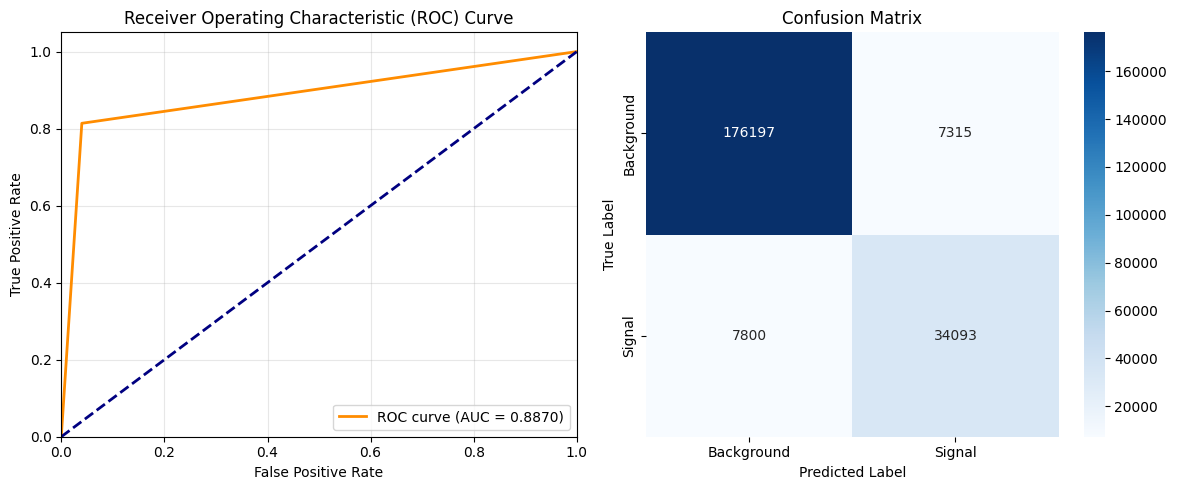

In [ ]:
# Let's see how well our model works on the validation set (data it hasn't seen before).
# We use several metrics:
# - Classification report: shows accuracy, precision, recall, etc.
# - Confusion matrix: shows how many events were correctly/incorrectly classified
# - ROC AUC: measures how well the model separates signal from background
# - ROC curve: visualizes the trade-off between true and false positives

print("=== MODEL PERFORMANCE EVALUATION ===")

# Classification report
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
print(f"\nConfusion Matrix:")
print(cm)

# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Plot confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Background', 'Signal'],
            yticklabels=['Background', 'Signal'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()


 #### Feature Importance Analysis

In [ ]:
# Analyze feature importance
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Get feature importance from the trained model
feature_names = combined_clean.drop(columns=['status']).columns
feature_importance = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20))


=== FEATURE IMPORTANCE ANALYSIS ===
Top 20 Most Important Features:
      feature  importance
70   lep_1_pt    0.153621
11    jet_2_m    0.133752
32    jet_5_m    0.058047
20   jet_3_pt    0.048803
14    jet_3_E    0.048350
52  jet_8_jvf    0.044170
87     met_et    0.036236
6    jet_1_pt    0.035372
4     jet_1_m    0.033359
63      jet_n    0.031065
13   jet_2_pt    0.020582
81   lep_2_pt    0.020422
61  jet_9_phi    0.016278
58  jet_9_eta    0.015189
56    jet_9_E    0.014870
57  jet_9_MV1    0.014627
60    jet_9_m    0.014193
62   jet_9_pt    0.012785
0     jet_1_E    0.012154
7     jet_2_E    0.010688


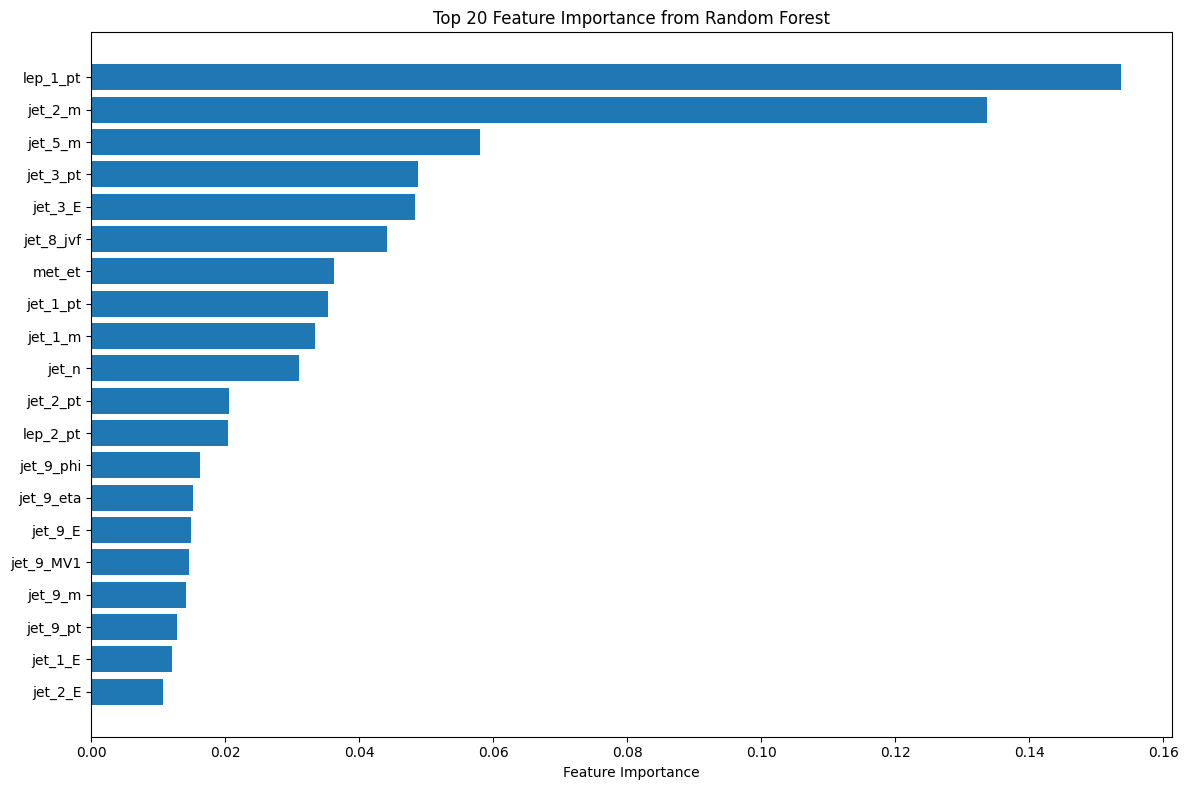

In [ ]:

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_20_features = importance_df.head(20)
plt.barh(range(len(top_20_features)), top_20_features['importance'])
plt.yticks(range(len(top_20_features)), top_20_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



 Based on the feature importance analysis, the most relevant features for our Z' boson detection model are the kinematics of the two leading jet and lepton. Nevertheless we can see the contribution of jet_9 also. By chosing these selected features we can reduce dimensionality while maintaining predictive power, following the principle that not all measured variables contribute equally to distinguishing signal from background events.

### Test on unpredicted ZPrime mass.

In [ ]:
### Testing our data for new or other possible process that it has never seen and apply the same preprocesssing as the train data

signal_test_only_df = process_files(signal_test_only_path,s_test_files)
signal_test_only_df = signal_test_only_df.drop(columns=all_features_to_remove, errors='ignore')
signal_test_only_df


Processing /kaggle/input/zparticlesearch/Signal_test_only files: 100%|██████████| 2/2 [00:00<00:00,  3.23file/s]

Successfully loaded 46157 events from 2 files


,jet_1_E,jet_1_MV1,jet_1_eta,jet_1_jvf,jet_1_m,jet_1_phi,jet_1_pt,jet_2_E,jet_2_MV1,jet_2_eta,jet_2_jvf,jet_2_m,jet_2_phi,jet_2_pt,jet_3_E,jet_3_MV1,jet_3_eta,jet_3_jvf,jet_3_m,jet_3_phi,jet_3_pt,jet_4_E,jet_4_MV1,jet_4_eta,jet_4_jvf,jet_4_m,jet_4_phi,jet_4_pt,jet_5_E,jet_5_MV1,jet_5_eta,jet_5_jvf,jet_5_m,jet_5_phi,jet_5_pt,jet_6_E,jet_6_MV1,jet_6_eta,jet_6_jvf,jet_6_m,jet_6_phi,jet_6_pt,jet_7_E,jet_7_MV1,jet_7_eta,jet_7_jvf,jet_7_m,jet_7_phi,jet_7_pt,jet_8_E,jet_8_MV1,jet_8_eta,jet_8_jvf,jet_8_m,jet_8_phi,jet_8_pt,jet_9_E,jet_9_MV1,jet_9_eta,jet_9_jvf,jet_9_m,jet_9_phi,jet_9_pt,jet_n,lep_1_E,lep_1_charge,lep_1_eta,lep_1_etcone20,lep_1_flag,lep_1_phi,lep_1_pt,lep_1_ptcone30,lep_1_trackd0pvunbiased,lep_1_type,lep_1_z0,lep_2_E,lep_2_charge,lep_2_eta,lep_2_etcone20,lep_2_flag,lep_2_phi,lep_2_pt,lep_2_ptcone30,lep_2_trackd0pvunbiased,lep_2_type,lep_2_z0,lep_n,met_et,met_phi,pvxp_n,vxp_z,status
0,3.951252e+05,0.994434,0.455923,1.000000,17375.402344,1.515362,3.569925e+05,478307.437500,0.458064,-1.306056,0.945068,25126.503906,-1.352670,241085.406250,307767.250000,0.055176,0.986158,0.996193,9690.096680,1.622278,201455.578125,134204.921875,0.054907,-0.295809,1.000000,17229.562500,1.904529,127476.273438,55684.363281,0.057785,0.261686,0.956176,7795.660156,2.190040,53300.542969,61185.992188,0.057234,1.020050,1.000000,2461.664551,-0.248312,39016.074219,35616.343750,0.057601,0.127821,1.00000,5748.996582,-0.301783,34864.097656,52388.093750,0.052396,-1.031231,0.03778,6134.317871,2.556781,32917.644531,27153.654297,0.059842,-0.326404,0.848023,4799.416992,2.831976,25363.015625,7,809299.500000,-1.0,-1.401077,2171.902588,1309114624,-1.767017,375902.406250,0.000000,0.015640,1095761920,0.011749,29613.333984,-1.0,0.432958,347.823730,1300955648,1.151897,27039.041016,0.0,-0.016258,1095761920,-0.008768,1,92695.054688,-1.655326,6,35.114388,1
1,1.101424e+06,0.991278,0.241321,0.998823,161653.218750,-2.972718,1.058525e+06,754445.437500,0.054671,-0.293437,0.991575,90152.375000,0.440482,717909.437500,165616.421875,0.055151,0.683091,0.932111,15078.757812,-0.192839,132737.015625,71717.195312,0.057611,0.404021,0.909970,13744.651367,-2.355950,65009.382812,178030.687500,0.994451,-1.719729,0.981938,8646.744141,-0.651035,61720.410156,49177.718750,0.057307,0.252796,1.000000,10251.691406,-1.614917,46600.347656,37317.238281,0.054192,0.340404,0.00000,5356.836914,2.814546,34889.742188,52388.093750,0.052396,-1.031231,0.03778,6134.317871,2.556781,32917.644531,27153.654297,0.059842,-0.326404,0.848023,4799.416992,2.831976,25363.015625,6,196013.343750,-1.0,-1.042179,2608.955078,1309098368,0.463092,122966.671875,0.000000,-0.001666,1093664768,0.017151,29613.333984,-1.0,0.432958,347.823730,1300955648,1.151897,27039.041016,0.0,-0.016258,1095761920,-0.008768,1,154641.406250,-0.059268,8,6.901551,1
2,9.244879e+05,0.932827,-0.138843,0.983858,80060.523438,-0.242626,9.122081e+05,613854.812500,0.994450,-0.838711,0.995070,38129.355469,2.861882,446283.656250,117262.929688,0.054868,0.726935,0.945975,10919.957031,2.196339,91495.257812,81007.257812,0.055659,-0.806929,0.954932,9284.652344,0.103689,59892.968750,40961.894531,0.145463,0.066018,0.834206,6591.676758,2.984497,40340.101562,49177.718750,0.057307,0.252796,1.000000,10251.691406,-1.614917,46600.347656,37317.238281,0.054192,0.340404,0.00000,5356.836914,2.814546,34889.742188,52388.093750,0.052396,-1.031231,0.03778,6134.317871,2.556781,32917.644531,27153.654297,0.059842,-0.326404,0.848023,4799.416992,2.831976,25363.015625,5,140814.062500,1.0,-1.185801,3743.872070,1309098368,-2.941556,78693.242188,0.000000,-0.053622,1093664768,0.042347,29613.333984,-1.0,0.432958,347.823730,1300955648,1.151897,27039.041016,0.0,-0.016258,1095761920,-0.008768,1,353408.437500,3.130240,13,-64.051727,1
3,7.133764e+05,0.952916,0.529227,0.998198,87288.359375,2.244019,6.192525e+05,437669.718750,0.052830,0.510549,1.000000,40627.742188,1.114280,384561.812500,256989.968750,0.615175,-0.569247,1.000000,10149.959961,-1.289967,220147.281250,94519.796875,0.054632,0.956111,0

In [ ]:

# Select the data
"""
X = scaler.fit_transform(signal_test_only_df.drop(columns=['status']))
y = signal_test_only_df['status']
"""
X = signal_test_only_df.drop(columns=['status'])
y = signal_test_only_df['status']

# Make predictions on the validation set
# y_test_pred: predicted class (signal/background)
# y_test_proba: predicted probability of being signal
y_test_pred = rf_classifier.predict(X)

print("=== MODEL PERFORMANCE EVALUATION ON UNSEEN DATA ===")

# Classification report
print("Classification Report (Test Set):")
print(classification_report(y, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y, y_test_pred)
print(f"\nConfusion Matrix:")
print(cm)


=== MODEL PERFORMANCE EVALUATION ON UNSEEN DATA ===
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.93      0.97     46157

    accuracy                           0.93     46157
   macro avg       0.50      0.47      0.48     46157
weighted avg       1.00      0.93      0.97     46157


Confusion Matrix:
[[    0     0]
 [ 3050 43107]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We can see  the accuracy of our model drop significantly when we test it with a data that it has never seen before, a different Z prime bosons with a new masses that wasn't in the dataset train. Nevertheless on these new data our model perform better than a random guessing. This shows the ability of our model to detect a possible new physics without training it to detect them. With more robust method this can be improvd in future work.

## Results and Interpretation

Our analysis successfully applied a Random Forest classifier to our datasets for the search of a hypothetical Z' boson decaying into top-antitop pairs.

This rigorous approach yielded significant insights:

* **Effective Feature Selection:** We efficiently reduced the high dimensionality of the dataset by removing irrelevant metadata, simulation-specific information, and redundant features (e.g., opting for `MV1` over `SV0`, and focusing on leading lepton kinematics). This pre-processing was crucial for model performance and interpretability.


* **Physically Meaningful Features:** Feature importance analysis consistently highlighted that the kinematic variables of the leading and sub-leading jets and leptons, along with missing transverse energy (`met_et`), are the most discriminative. This aligns perfectly with theoretical expectations for a massive Z' boson's decay, as these variables directly encode the energy, momentum, and topology of its energetic decay products.

* **Ability to work on unseen data :** A machine learning model, trained with well chosen features can helps physicist to detetct new particles or new physics without even predicting it in theory. However the test shows how weak our machine learnin algorithm when facing uncertainity. With more robust approach such as deep learning in future work the prediction accuracy can be enhanced significantly.

These findings underscore the model's strong ability to distinguish Z' signal from Standard Model backgrounds, driven by features that are directly interpretable through the lens of particle physics theory.



## Conclusion & Future Work

This project demonstrated the effectiveness of Machine Learning, specifically a Random Forest classifier, for Z' boson detection. Our work highlights that a strong data analytical approach, particularly  feature selection, is paramount to overcome the "curse of dimensionality" inherent in complex physics datasets and achieve robust model performance.

The most discriminative features for Z' boson detection were identified as the kinematics of the leading jets and leptons, which directly relate to the fundamental properties and decay signatures of such a massive particle. This consistency between model-derived importance and theoretical understanding strengthens the potential of our approach for new physics searches.

**Future Work will focus on:**

1.  Invariant Mass Reconstruction: Reconstructing the invariant mass of the candidate Z' boson from the identified key features. This is critical for observing a resonant peak, although background suppression around this peak will be a significant challenge.
2.  Advanced Machine Learning: Exploring more powerful techniques like deep neural networks to potentially uncover more subtle correlations and further enhance sensitivity.And also to work on the possiblity to detect new particles.


# References/Data Sources

- Risholm, L. E. (2023). *Z' Particle Search Dataset*. Kaggle. Retrieved from https://www.kaggle.com/datasets/larserikrisholm/zparticlesearch
- Hdf5 documentation . [Handle Hdf5](https://docs.h5py.org/en/stable/)
- Z' boson. (n.d.). *Chemeurope*.  https://www.chemeurope.com/en/encyclopedia/Z%27_boson.html
- CMS Collaboration. (2025). *Dark matter and pencil jets: The search for a low-mass Z' boson using machine learning*. CERN.  https://cms.cern/news/dark-matter-and-pencil-jets-search-low-mass-z-boson-using-machine-learning
- Curse of dimensionality. (2024, June 29). In *Wikipedia*. Retrieved from https://en.wikipedia.org/wiki/Curse_of_dimensionality
- CERN Open Data Portal. (n.d.). https://opendata.cern.ch/